## 1. Efficient Net download
Install efficientnet downloaded from github. If using Kaggle, please switch on internet.

In [1]:
# output is hidden in view version
!pip3 install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-22c4l4s0
     |████████████████████████████████| 50 kB 770 kB/s eta 0:00:011
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18420 sha256=001de10e9673d10db12aefd15cb835b4f2263352c4df7feeaa42e749e3a61f07
  Stored in directory: /tmp/pip-ephem-wheel-cache-z9a6n2gq/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 2. Import packages
<span style = "color:red"> Could we remove the imports that aren't being used? </span>

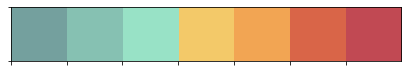

In [2]:
# Regular Imports
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import seaborn as sns
import math
import cv2
import pydicom
import os
import glob
import pickle as pkl
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
from skimage.transform import resize
import copy
import re
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Segmentation
import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

# Model imports
import tensorflow as tf 
from tensorflow.keras.layers import (
                                    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D,
                                    Add, Conv2D, AveragePooling2D, LeakyReLU, Concatenate , Lambda
                                    )
from tensorflow.keras import Model
import tensorflow.keras.models as M
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
# import tensorflow.keras.applications as tfa
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns
import plotly.express as px



pd.set_option("display.max_columns", 100)
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.palplot(sns.color_palette(custom_colors))

## 3. Tuned Hyperparameters
We define the number of -
* **epochs** : the number of times we loop through the dataset. 
* **batch_size**: how many training examples to feed into network before updating the weights and internal nodes
* **LR**: learning rate
* **MODEL_CLASS**:  allow us to define which efficientnet model we want to use
* **SAVE_BEST**: defined as true, to only save the model due to 'early stopping' implemented

In [3]:
EPOCHS = 40
BATCH_SIZE = 8
NFOLD = 5
LR = 0.003
SAVE_BEST = True
MODEL_CLASS = 'b1'
path = '../input/osic-pulmonary-fibrosis-progression'

## 4. Train-Test split
We create a test dataset with 20% of unique patients and their associated data; 80% for training. 
Duplicates are dropped as some patients have more than one recorded FVC value for each week. 

In [4]:
all_data = pd.read_csv(f'{path}/train.csv') 
all_data.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
unique_patients = all_data.Patient.unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train = all_data[all_data['Patient'].isin(train_ids)]
test = all_data[all_data['Patient'].isin(test_ids)]

In [5]:
train.groupby('Sex').agg('count')

,Patient,Weeks,FVC,Percent,Age,SmokingStatus
Sex,,,,,,
Female,246,246,246,246,246,246
Male,977,977,977,977,977,977


In [6]:
fig = px.scatter(train, x="Sex", y ="FVC")
fig.show()

In [7]:
fig = px.scatter(test, x="Sex", y ="FVC")
fig.show()

In [ ]:
# BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
# a = test["Patient"].values
# for b in BAD_ID:
#     if b in a:
#         print(True)

## 5. Data Preprocessing
The original features of the data included Age, Smoking_Status, Sex, Weeks, Percent. However, we would like to transform the data, and include altered features. 

The features that will be fed into the model eventually include:
* baseline Age (numerical)
* baseline Percent (numerical)
* Gender (encoded)
* Smoking status (encoded)

Along with that, the numerical data is normalised and categorical variables are one-hot encoded.

In [8]:
def get_baseline_week(df):    
    # make a copy to not change original df    
    _df = df.copy()
    # ensure all Weeks values are INT and not accidentaly saved as string
    _df['Weeks'] = _df['Weeks'].astype(int)
    _df['min_week'] = _df['Weeks']
    _df["min_week"] = _df.groupby('Patient')['Weeks'].transform('min')
    _df['baselined_week'] = _df['Weeks'] - _df['min_week']
    
    return pd.DataFrame(_df)

In [9]:
train = get_baseline_week(train)
#train = get_baseline_FVC_new(train)
test = get_baseline_week(test)
#test = get_baseline_FVC_new(test)

In [10]:
# define which attributes shall not be transformed, are numeric or categorical
no_transform_attribs = ['Patient', 'Weeks', 'min_week', 'FVC']
num_attribs = ['Percent', 'Age']
cat_attribs = ['Sex', 'SmokingStatus']

In [11]:
from sklearn import preprocessing

num_attribs_scld = [s + '_scld' for s in num_attribs]

min_max_scaler = preprocessing.MinMaxScaler()
train[num_attribs_scld] = min_max_scaler.fit_transform(train[num_attribs])
test[num_attribs_scld] = min_max_scaler.transform(test[num_attribs])

In [ ]:
# train.head()

In [ ]:
# test.head()

Encoding our categorical variables. 
* Gender: Male: 0, Female: 1
* Smoking_Status: Never Smoked: [0,0], Ex-Smoker: [1,1], Currently Smokes: [0,1]


In [12]:
def get_tab_scaled(df): #getting scaled variables
    vector = [df.Percent_scld.values[0]] # only the first percent value is retained, so this forms the "base_percent"
    vector.extend([df.Age_scld.values[0]]) # only the first age value is retained, so this forms the "base age"
    if df.Sex.values[0].lower() == 'male':
        vector.append(0)
    else:
        vector.append(1)
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    
    return np.array(vector)

We need to create the labels i.e y values for our dataset. We aim to predict the rate of FVC values deterioration, which would be the gradient of a linear regression model fit to every available patient. 

In [13]:
A = {} # Gradient of the linear regression of FVC against weeks 
TAB = {} # Initialize tabular data for each patient
P = [] # Patient IDs

# for all 140 train patients we compute the gradient 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values    
    weeks = sub.Weeks.values 
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab_scaled(sub)
    # TAB[p] = get_tab_unscaled(sub)
    P.append(p)

In [14]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-4,0,0.202489,0.789474
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-4,9,0.181129,0.789474
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,-4,11,0.148772,0.789474
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,-4,13,0.166325,0.789474
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,-4,15,0.150464,0.789474


In [15]:
train_grad = train.copy()
train_grad['gradient'] = train_grad['Patient'].map(A)
train_grad.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld,gradient
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-4,0,0.202489,0.789474,-3.167126
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-4,9,0.181129,0.789474,-3.167126
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,-4,11,0.148772,0.789474,-3.167126
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,-4,13,0.166325,0.789474,-3.167126
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,-4,15,0.150464,0.789474,-3.167126


In [ ]:
train_grad.loc[train_grad.gradient == train_grad.gradient.max()]

In [ ]:
sns.lineplot(data = train_grad.loc[train_grad.Patient == 'ID00197637202246865691526'].FVC)

In [ ]:
sns.set_style("whitegrid") 
sns.boxplot(x = 'SmokingStatus', y = 'gradient', data = train_grad.drop_duplicates(subset=['Patient'])) 

In [ ]:
sns.boxplot(x = 'Sex', y = 'gradient', data = train_grad.drop_duplicates(subset=['Patient'])) 

In [ ]:
sns.distplot(train_grad['Age'])

In [ ]:
train_grad['Age bin'] =  

For each sliced ct scan, we need to resize into 512x512 pixel dimensions. 

In [16]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512, 512))

There are patients (labelled with BAD_IDs ( <span style = "color:red"> why are they bad_IDs maybe we need to explain that ? </span> )) that need to be removed from the training data. This class also transforms the dataframes into the required numpy arrays so that our data can be input into the neural network. 

In [17]:
class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID] # all the patients in the keys  
        self.a = a # gradients found by fitting a linear regression model
        self.tab = tab # tabular data for patient specified in keys
        self.batch_size = batch_size
        
        self.train_data = {} # initialise a dictionary to contain all the images pertaining to one key: patient id 
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000 # 1000 batches per epoch
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size) # randomly chosen n patients for one batch  
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x] , a

## 7. Model Definition

In [18]:
def get_efficientnet(model, shape):
    '''
    From https://github.com/qubvel/efficientnet
    EfficientNet is a CNN architecture achieving state of the art accuracy.
    b0 is the simplest model, b7 is the most complex.
    '''
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False), # We use a b1 efficientnet
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape) # 512 x 512 input shape
    base = get_efficientnet(model_class, shape) # A b1 pre-trained efficientnet is used
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(4,))
    out_tab = tf.keras.layers.GaussianNoise(0.2)(inp2) # add some noise to our data
    
    x2 = Concatenate()([x, out_tab]) 
    
    #### added ###
    den_1 = Dense(20)(x) # linear layer with 50 output nodes
    den_1 = LeakyReLU(alpha=0.3)(den_1) # default alpha is 0.3
    den_2 = Dense(500)(den_1)
    den_2 = LeakyReLU(alpha=0.3)(den_2)
    bn_1 = BatchNormalization()(den_2)
    den_3 = Dense(100)(bn_1)
    
    x3 = Dropout(0.5)(den_3) # move the dropout layer to before the linear layers 
    
    # the linear layers here are akin to the final dense layer usually used in a "before concat" model
    out_1 = Dense(1)(x3)
    out_2 = Dense(1, activation='relu')(x3)
    y = out_1 + tf.keras.backend.cumsum(out_2, axis=1)
    
    model = Model([inp], y)
    return model

## 8. Model Training

We split the dataset into 5 folds for cross validation purposes. There is early stopping employed in the model and the loss function that we decided upon is RMSE = Root Mean Squared Error. It is a commonly used loss function in regression problems.  <span style = "color:red"> do we need to change mse in the code to rmse ? </span>

In [ ]:
kf = KFold(n_splits=NFOLD, random_state=42,shuffle=False)
P = np.array(P)
subs = []
folds_history = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(P)):
    print('#####################')
    print('####### Fold %i ######'%fold)
    print('#####################')
    print('Training...')
    
    er = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-3,
        patience=8,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    cpt = tf.keras.callbacks.ModelCheckpoint(
        filepath='fold-%i.h5'%fold,
        monitor='val_loss', 
        verbose=1, 
        save_best_only=SAVE_BEST,
        mode='auto'
    )

    rlp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,
        patience=5, 
        verbose=1, 
        min_lr=1e-8
    )
    model = build_model(model_class=MODEL_CLASS)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse") 
    history = model.fit_generator(IGenerator(keys=P[tr_idx], 
                                   a = A, 
                                   tab = TAB), 
                        steps_per_epoch = 32,
                        validation_data=IGenerator(keys=P[val_idx], 
                                   a = A, 
                                   tab = TAB),
                        validation_steps = 16, 
                        callbacks = [cpt, rlp], 
                        epochs=EPOCHS)
    folds_history.append(history.history)
    print('Training done!')

## 9. Validation Loss examination

In [ ]:
min_array = []
for i in range(5):
    min_array.append(min(folds_history[i]['val_loss']))
    print(i, min(folds_history[i]['val_loss']))
print(min(min_array))

In [ ]:
# We pick the best model (weights) based on cross validation score.
if SAVE_BEST:
    mean_val_loss = np.mean([np.min(h['val_loss']) for h in folds_history])
else:
    mean_val_loss = np.mean([h['val_loss'][-1] for h in folds_history])
print('Our mean CV MAE is: ' + str(mean_val_loss))

min_fold finds out which fold gives the least validation loss

In [ ]:
min_fold = np.argmin([np.min(h['val_loss']) for h in folds_history])

In [20]:
min_fold = 1

^print what is the fold that gives min loss, keep a record below 

In [21]:
################################
# min_fold = 1 #change accordingly
################################
#uncomment for using notebook

1. download the weights from the output and save to zip file and upload them 
2. Restart kernel at this point for fitting weights from best fold to model in model building

building model for prediction

## 10. Model for Test Data

In [22]:
def build_pred_model(shape=(512, 512, 1), model_class=None, fold=None):
    inp = Input(shape=shape) # 512 x 512 input shape
    base = get_efficientnet(model_class, shape) # A b1 pre-trained efficientnet is used
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(5,))
    out_tab = tf.keras.layers.GaussianNoise(0.2)(inp2) # add some noise to our data
    
    x2 = Concatenate()([x, out_tab]) 
    
    #### added ###
    den_1 = Dense(20)(x2) # linear layer with 50 output nodes
    den_1 = LeakyReLU(alpha=0.3)(den_1) # default alpha is 0.3
    den_2 = Dense(500)(den_1)
    den_2 = LeakyReLU(alpha=0.3)(den_2)
    bn_1 = BatchNormalization()(den_2)
    den_3 = Dense(100)(bn_1)
    
    x3 = Dropout(0.5)(den_3) # move the dropout layer to before the linear layers 
    
    # the linear layers here are akin to the final dense layer usually used in a "before concat" model
    out_1 = Dense(1)(x3)
    out_2 = Dense(1, activation='relu')(x3)
    y = out_1 + tf.keras.backend.cumsum(out_2, axis=1)
    
    model = Model([inp, inp2], y)
    
    # Take from kaggle  working output
    weights = [w for w in os.listdir('../input/best-model-fold/') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    model.load_weights('../input/best-model-fold/' + weights) #use dir of './' if using training above, else can just use my trained weights in input
    
    #take weights from uploaded weights
    #uncomment when using notebook, instead of when committing notebook
    #weights = [w for w in os.listdir('../input/scaled-weights-genderagepercentsmoker/') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    #model.load_weights('../input/scaled-weights-genderagepercentsmoker/' + weights) #use dir of './' if using training above, else can just use my trained weights in input
    return model
#models = [build_pred_model(shape=(512, 512, 1), model_class='b1', fold=min_fold)]
#uncomment the above to build model from the weights trained above, else can use the below code for building model
models = [build_pred_model(shape=(512, 512, 1), model_class='b1', fold=min_fold)]

In [23]:
subs = []
q = 0.5
weeks = list(range(-12, 134))
predictions = []
for model in models:
    metric = []
    
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15: # what is this? only certain slices are being extracted for patients?
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                tab.append(get_tab_scaled(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        print(len(test[test.Patient == p])) # number of fvc values to predict for every week
        tab = np.array(tab) 
        print("number of patient data is: ", len(tab))
        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) # Predict from all image data and tabular data.
        a = np.quantile(_a, q) # Get the value at the 50th percentile
        
        A_test[p] = a
        print("number of patient FVC data is: ", len(test.FVC.values[test.Patient == p])) # number of times patient takes
        #######################################################################################################################################
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p] #to find the y intercept   #
        #######################################################################################################################################
        print("B_test[p] is: ", B_test[p])
        #B_test is actually to find the intercept
        
        #P_test[p] = test.Percent_scld.values[test.Patient == p] 
        #print("P_test[p] is: ", P_test[p])
        #WEEK[p] = test.baselined_week_scld.values[test.Patient == p]
        #print("WEEK[p] is: ", WEEK[p])
    
    for p in test.Patient.unique():
        for w in weeks:
            patient_prediction = {}
            fvc = A_test[p] * w + B_test[p]  #y = mx + c, A_test[p] = gradient of progression for patient p, w = week_num, B_test[p] is the calculated y_intercept
            print("fvc is: ", fvc)
            patient_prediction = {
                'Week': w,
                'Patient': p,
                'FVC': np.sum(fvc)/len(fvc)
            }
            predictions.append(patient_prediction)
print('done!')

9
number of patient data is:  17
number of patient FVC data is:  9
B_test[p] is:  [1522.46476078 1381.53523922 1383.55873203 1496.58222485 1721.60571766
 1528.6761961  1458.81715298 1479.95810986 1654.14605236]
9
number of patient data is:  233
number of patient FVC data is:  9
B_test[p] is:  [2513.44351673 2843.35076952 2805.25802231 2759.1652751  2966.43340707
 2636.79428625 2695.23780298 2715.13494611 2605.93934202]
9
number of patient data is:  373
number of patient FVC data is:  9
B_test[p] is:  [2763.3980124  2641.61601353 2679.05201578 2719.48801804 2741.92402029
 2864.23202705 2506.84804058 2352.68205523 2481.17007327]
9
number of patient data is:  225
number of patient FVC data is:  9
B_test[p] is:  [3965.74633408 3944.49266815 3836.36583519 4043.94794655 4062.53005791
 3909.9853363  3964.47800446 4039.26172829 4103.3365078 ]
6
number of patient data is:  67
number of patient FVC data is:  6
B_test[p] is:  [3319.7611084  3248.5222168  3390.2833252  3156.04443359 3269.80554199


 1560.25842094 1490.39937782 1511.5403347  1685.72827721]
fvc is:  [1549.53523922 1408.60571766 1410.62921047 1523.65270329 1748.6761961
 1555.74667454 1485.88763142 1507.02858829 1681.2165308 ]
fvc is:  [1545.02349281 1404.09397125 1406.11746407 1519.14095688 1744.16444969
 1551.23492813 1481.37588501 1502.51684189 1676.70478439]
fvc is:  [1540.51174641 1399.58222485 1401.60571766 1514.62921047 1739.65270329
 1546.72318172 1476.8641386  1498.00509548 1672.19303799]
fvc is:  [1536.         1395.07047844 1397.09397125 1510.11746407 1735.14095688
 1542.21143532 1472.3523922  1493.49334908 1667.68129158]
fvc is:  [1531.48825359 1390.55873203 1392.58222485 1505.60571766 1730.62921047
 1537.69968891 1467.84064579 1488.98160267 1663.16954517]
fvc is:  [1526.97650719 1386.04698563 1388.07047844 1501.09397125 1726.11746407
 1533.1879425  1463.32889938 1484.46985626 1658.65779877]
fvc is:  [1522.46476078 1381.53523922 1383.55873203 1496.58222485 1721.60571766
 1528.6761961  1458.81715298 1479.9

fvc is:  [1283.34220123 1142.41267967 1144.43617249 1257.4596653  1482.48315811
 1289.55363655 1219.69459343 1240.83555031 1415.02349281]
fvc is:  [1278.83045483 1137.90093327 1139.92442608 1252.94791889 1477.97141171
 1285.04189014 1215.18284702 1236.3238039  1410.51174641]
fvc is:  [1274.31870842 1133.38918686 1135.41267967 1248.43617249 1473.4596653
 1280.53014374 1210.67110062 1231.8120575  1406.        ]
fvc is:  [1269.80696201 1128.87744045 1130.90093327 1243.92442608 1468.94791889
 1276.01839733 1206.15935421 1227.30031109 1401.48825359]
fvc is:  [1265.29521561 1124.36569405 1126.38918686 1239.41267967 1464.43617249
 1271.50665092 1201.6476078  1222.78856468 1396.97650719]
fvc is:  [1260.7834692  1119.85394764 1121.87744045 1234.90093327 1459.92442608
 1266.99490452 1197.1358614  1218.27681828 1392.46476078]
fvc is:  [1256.27172279 1115.34220123 1117.36569405 1230.38918686 1455.41267967
 1262.48315811 1192.62411499 1213.76507187 1387.95301437]
fvc is:  [1251.75997639 1110.830454

 1023.36059856  953.50155544  974.64251232 1148.83045483]
fvc is:  [1012.63741684  871.70789528  873.73138809  986.75488091 1211.77837372
 1018.84885216  948.98980904  970.13076591 1144.31870842]
fvc is:  [1008.12567043  867.19614887  869.21964169  982.2431345  1207.26662731
 1014.33710575  944.47806263  965.61901951 1139.80696201]
fvc is:  [1003.61392403  862.68440247  864.70789528  977.73138809 1202.75488091
 1009.82535934  939.96631622  961.1072731  1135.29521561]
fvc is:  [ 999.10217762  858.17265606  860.19614887  973.21964169 1198.2431345
 1005.31361294  935.45456982  956.5955267  1130.7834692 ]
fvc is:  [ 994.59043121  853.66090965  855.68440247  968.70789528 1193.73138809
 1000.80186653  930.94282341  952.08378029 1126.27172279]
fvc is:  [ 990.07868481  849.14916325  851.17265606  964.19614887 1189.21964169
  996.29012012  926.431077    947.57203388 1121.75997639]
fvc is:  [ 985.5669384   844.63741684  846.66090965  959.68440247 1184.70789528
  991.77837372  921.9193306   943.0

fvc is:  [2423.64923048 2753.55648327 2715.46373606 2669.37098885 2876.63912082
 2547.         2605.44351673 2625.34065986 2516.14505577]
fvc is:  [2420.19560409 2750.10285687 2712.01010966 2665.91736245 2873.18549442
 2543.54637361 2601.98989034 2621.88703346 2512.69142938]
fvc is:  [2416.74197769 2746.64923048 2708.55648327 2662.46373606 2869.73186803
 2540.09274721 2598.53626394 2618.43340707 2509.23780298]
fvc is:  [2413.2883513  2743.19560409 2705.10285687 2659.01010966 2866.27824163
 2536.63912082 2595.08263755 2614.97978067 2505.78417659]
fvc is:  [2409.8347249  2739.74197769 2701.64923048 2655.55648327 2862.82461524
 2533.18549442 2591.62901115 2611.52615428 2502.33055019]
fvc is:  [2406.38109851 2736.2883513  2698.19560409 2652.10285687 2859.37098885
 2529.73186803 2588.17538476 2608.07252789 2498.8769238 ]
fvc is:  [2402.92747211 2732.8347249  2694.74197769 2648.64923048 2855.91736245
 2526.27824163 2584.72175837 2604.61890149 2495.42329741]
fvc is:  [2399.47384572 2729.38109

 2343.23604274 2401.67955947 2421.57670259 2312.38109851]
fvc is:  [2216.43164682 2546.33889961 2508.2461524  2462.15340519 2669.42153716
 2339.78241634 2398.22593307 2418.1230762  2308.92747211]
fvc is:  [2212.97802043 2542.88527322 2504.79252601 2458.6997788  2665.96791077
 2336.32878995 2394.77230668 2414.66944981 2305.47384572]
fvc is:  [2209.52439404 2539.43164682 2501.33889961 2455.2461524  2662.51428437
 2332.87516356 2391.31868029 2411.21582341 2302.02021933]
fvc is:  [2206.07076764 2535.97802043 2497.88527322 2451.79252601 2659.06065798
 2329.42153716 2387.86505389 2407.76219702 2298.56659293]
fvc is:  [2202.61714125 2532.52439404 2494.43164682 2448.33889961 2655.60703158
 2325.96791077 2384.4114275  2404.30857062 2295.11296654]
fvc is:  [2199.16351485 2529.07076764 2490.97802043 2444.88527322 2652.15340519
 2322.51428437 2380.9578011  2400.85494423 2291.65934014]
fvc is:  [2195.70988846 2525.61714125 2487.52439404 2441.43164682 2648.6997788
 2319.06065798 2377.50417471 2397.4

fvc is:  [2766.61601353 2644.83401465 2682.27001691 2722.70601916 2745.14202142
 2867.45002818 2510.06604171 2355.90005636 2484.3880744 ]
fvc is:  [2763.3980124  2641.61601353 2679.05201578 2719.48801804 2741.92402029
 2864.23202705 2506.84804058 2352.68205523 2481.17007327]
fvc is:  [2760.18001127 2638.3980124  2675.83401465 2716.27001691 2738.70601916
 2861.01402593 2503.63003945 2349.46405411 2477.95207214]
fvc is:  [2756.96201015 2635.18001127 2672.61601353 2713.05201578 2735.48801804
 2857.7960248  2500.41203833 2346.24605298 2474.73407102]
fvc is:  [2753.74400902 2631.96201015 2669.3980124  2709.83401465 2732.27001691
 2854.57802367 2497.1940372  2343.02805185 2471.51606989]
fvc is:  [2750.52600789 2628.74400902 2666.18001127 2706.61601353 2729.05201578
 2851.36002254 2493.97603607 2339.81005073 2468.29806876]
fvc is:  [2747.30800676 2625.52600789 2662.96201015 2703.3980124  2725.83401465
 2848.14202142 2490.75803494 2336.5920496  2465.08006763]
fvc is:  [2744.09000564 2622.30800

 2677.58796167 2320.2039752  2166.03798985 2294.52600789]
fvc is:  [2573.53594589 2451.75394702 2489.18994927 2529.62595153 2552.06195378
 2674.36996055 2316.98597407 2162.81998873 2291.30800676]
fvc is:  [2570.31794477 2448.53594589 2485.97194815 2526.4079504  2548.84395266
 2671.15195942 2313.76797295 2159.6019876  2288.09000564]
fvc is:  [2567.09994364 2445.31794477 2482.75394702 2523.18994927 2545.62595153
 2667.93395829 2310.54997182 2156.38398647 2284.87200451]
fvc is:  [2563.88194251 2442.09994364 2479.53594589 2519.97194815 2542.4079504
 2664.71595716 2307.33197069 2153.16598535 2281.65400338]
fvc is:  [2560.66394138 2438.88194251 2476.31794477 2516.75394702 2539.18994927
 2661.49795604 2304.11396956 2149.94798422 2278.43600225]
fvc is:  [2557.44594026 2435.66394138 2473.09994364 2513.53594589 2535.97194815
 2658.27995491 2300.89596844 2146.72998309 2275.21800113]
fvc is:  [2554.22793913 2432.44594026 2469.88194251 2510.31794477 2532.75394702
 2655.06195378 2297.67796731 2143.5

fvc is:  [2383.67387938 2261.89188051 2299.32788277 2339.76388502 2362.19988728
 2484.50789404 2127.12390757 1972.95792222 2101.44594026]
fvc is:  [2380.45587826 2258.67387938 2296.10988164 2336.54588389 2358.98188615
 2481.28989291 2123.90590644 1969.73992109 2098.22793913]
fvc is:  [2377.23787713 2255.45587826 2292.89188051 2333.32788277 2355.76388502
 2478.07189178 2120.68790531 1966.52191997 2095.009938  ]
fvc is:  [2374.019876   2252.23787713 2289.67387938 2330.10988164 2352.54588389
 2474.85389066 2117.46990418 1963.30391884 2091.79193687]
fvc is:  [2370.80187488 2249.019876   2286.45587826 2326.89188051 2349.32788277
 2471.63588953 2114.25190306 1960.08591771 2088.57393575]
fvc is:  [2367.58387375 2245.80187488 2283.23787713 2323.67387938 2346.10988164
 2468.4178884  2111.03390193 1956.86791658 2085.35593462]
fvc is:  [2364.36587262 2242.58387375 2280.019876   2320.45587826 2342.89188051
 2465.19988728 2107.8159008  1953.64991546 2082.13793349]
fvc is:  [2361.14787149 2239.36587

 3807.96261024 3862.4552784  3937.23900223 4001.31378174]
fvc is:  [3860.43255234 3839.17888641 3731.05205345 3938.63416481 3957.21627617
 3804.67155457 3859.16422272 3933.94794655 3998.02272606]
fvc is:  [3857.14149666 3835.88783073 3727.76099777 3935.34310913 3953.92522049
 3801.38049889 3855.87316704 3930.65689087 3994.73167038]
fvc is:  [3853.85044098 3832.59677505 3724.46994209 3932.05205345 3950.63416481
 3798.08944321 3852.58211136 3927.36583519 3991.4406147 ]
fvc is:  [3850.5593853  3829.30571938 3721.17888641 3928.76099777 3947.34310913
 3794.79838753 3849.29105568 3924.07477951 3988.14955902]
fvc is:  [3847.26832962 3826.0146637  3717.88783073 3925.46994209 3944.05205345
 3791.50733185 3846.         3920.78372383 3984.85850334]
fvc is:  [3843.97727394 3822.72360802 3714.59677505 3922.17888641 3940.76099777
 3788.21627617 3842.70894432 3917.49266815 3981.56744766]
fvc is:  [3840.68621826 3819.43255234 3711.30571938 3918.88783073 3937.46994209
 3784.92522049 3839.41788864 3914.

fvc is:  [3666.26026726 3645.00660133 3536.87976837 3744.46187973 3763.04399109
 3610.49926949 3664.99193764 3739.77566147 3803.85044098]
fvc is:  [3662.96921158 3641.71554565 3533.58871269 3741.17082405 3759.75293541
 3607.20821381 3661.70088196 3736.48460579 3800.5593853 ]
fvc is:  [3659.6781559  3638.42448997 3530.29765701 3737.87976837 3756.46187973
 3603.91715813 3658.40982628 3733.19355011 3797.26832962]
fvc is:  [3656.38710022 3635.1334343  3527.00660133 3734.58871269 3753.17082405
 3600.62610245 3655.1187706  3729.90249443 3793.97727394]
fvc is:  [3653.09604454 3631.84237862 3523.71554565 3731.29765701 3749.87976837
 3597.33504677 3651.82771492 3726.61143875 3790.68621826]
fvc is:  [3649.80498886 3628.55132294 3520.42448997 3728.00660133 3746.58871269
 3594.04399109 3648.53665924 3723.32038307 3787.39516258]
fvc is:  [3646.51393318 3625.26026726 3517.1334343  3724.71554565 3743.29765701
 3590.75293541 3645.24560356 3720.02932739 3784.1041069 ]
fvc is:  [3643.2228775  3621.96921

 3072.84997559]
fvc is:  [3279.19445801 3207.95556641 3349.7166748  3115.4777832  3229.2388916
 3069.46942139]
fvc is:  [3275.81390381 3204.57501221 3346.33612061 3112.097229   3225.8583374
 3066.08886719]
fvc is:  [3272.43334961 3201.19445801 3342.95556641 3108.7166748  3222.4777832
 3062.70831299]
fvc is:  [3269.05279541 3197.81390381 3339.57501221 3105.33612061 3219.097229
 3059.32775879]
fvc is:  [3265.67224121 3194.43334961 3336.19445801 3101.95556641 3215.7166748
 3055.94720459]
fvc is:  [3262.29168701 3191.05279541 3332.81390381 3098.57501221 3212.33612061
 3052.56665039]
fvc is:  [3258.91113281 3187.67224121 3329.43334961 3095.19445801 3208.95556641
 3049.18609619]
fvc is:  [3255.53057861 3184.29168701 3326.05279541 3091.81390381 3205.57501221
 3045.80554199]
fvc is:  [3252.15002441 3180.91113281 3322.67224121 3088.43334961 3202.19445801
 3042.42498779]
fvc is:  [3248.76947021 3177.53057861 3319.29168701 3085.05279541 3198.81390381
 3039.04443359]
fvc is:  [3245.38891602 3174.1

 2782.12231445]
fvc is:  [2988.46679688 2917.22790527 3058.98901367 2824.75012207 2938.51123047
 2778.74176025]
fvc is:  [2985.08624268 2913.84735107 3055.60845947 2821.36956787 2935.13067627
 2775.36120605]
fvc is:  [2981.70568848 2910.46679688 3052.22790527 2817.98901367 2931.75012207
 2771.98065186]
fvc is:  [2978.32513428 2907.08624268 3048.84735107 2814.60845947 2928.36956787
 2768.60009766]
fvc is:  [2974.94458008 2903.70568848 3045.46679688 2811.22790527 2924.98901367
 2765.21954346]
fvc is:  [2971.56402588 2900.32513428 3042.08624268 2807.84735107 2921.60845947
 2761.83898926]
fvc is:  [2968.18347168 2896.94458008 3038.70568848 2804.46679688 2918.22790527
 2758.45843506]
fvc is:  [2964.80291748 2893.56402588 3035.32513428 2801.08624268 2914.84735107
 2755.07788086]
fvc is:  [2961.42236328 2890.18347168 3031.94458008 2797.70568848 2911.46679688
 2751.69732666]
fvc is:  [2958.04180908 2886.80291748 3028.56402588 2794.32513428 2908.08624268
 2748.31677246]
fvc is:  [2954.66125488 

 1460.49583054 1504.02180862]
fvc is:  [1312.53431702 1369.18088531 1396.82745361 1397.76715851 1422.6465683
 1456.17254639 1499.69852448]
fvc is:  [1308.21103287 1364.85760117 1392.50416946 1393.44387436 1418.32328415
 1451.84926224 1495.37524033]
fvc is:  [1303.88774872 1360.53431702 1388.18088531 1389.12059021 1414.
 1447.52597809 1491.05195618]
fvc is:  [1299.56446457 1356.21103287 1383.85760117 1384.79730606 1409.67671585
 1443.20269394 1486.72867203]
fvc is:  [1295.24118042 1351.88774872 1379.53431702 1380.47402191 1405.3534317
 1438.87940979 1482.40538788]
fvc is:  [1290.91789627 1347.56446457 1375.21103287 1376.15073776 1401.03014755
 1434.55612564 1478.08210373]
fvc is:  [1286.59461212 1343.24118042 1370.88774872 1371.82745361 1396.7068634
 1430.23284149 1473.75881958]
fvc is:  [1282.27132797 1338.91789627 1366.56446457 1367.50416946 1392.38357925
 1425.90955734 1469.43553543]
fvc is:  [1277.94804382 1334.59461212 1362.24118042 1363.18088531 1388.0602951
 1421.58627319 1465.11

 1136.24951935 1179.77549744]
fvc is:  [ 988.28800583 1044.93457413 1072.58114243 1073.52084732 1098.40025711
 1131.9262352  1175.45221329]
fvc is:  [ 983.96472168 1040.61128998 1068.25785828 1069.19756317 1094.07697296
 1127.60295105 1171.12892914]
fvc is:  [ 979.64143753 1036.28800583 1063.93457413 1064.87427902 1089.75368881
 1123.2796669  1166.80564499]
fvc is:  [ 975.31815338 1031.96472168 1059.61128998 1060.55099487 1085.43040466
 1118.95638275 1162.48236084]
fvc is:  [ 970.99486923 1027.64143753 1055.28800583 1056.22771072 1081.10712051
 1114.6330986  1158.15907669]
fvc is:  [ 966.67158508 1023.31815338 1050.96472168 1051.90442657 1076.78383636
 1110.30981445 1153.83579254]
fvc is:  [ 962.34830093 1018.99486923 1046.64143753 1047.58114243 1072.46055222
 1105.9865303  1149.51250839]
fvc is:  [ 958.02501678 1014.67158508 1042.31815338 1043.25785828 1068.13726807
 1101.66324615 1145.18922424]
fvc is:  [ 953.70173264 1010.34830093 1037.99486923 1038.93457413 1063.81398392
 1097.3399

 2364.10834694 2444.79364586 2435.95271969 2402.05934334]
fvc is:  [2386.00172329 2429.94927311 2443.89682293 2269.84437275 2380.79192257
 2359.63457203 2440.31987095 2431.47894478 2397.58556843]
fvc is:  [2381.52794838 2425.4754982  2439.42304802 2265.37059784 2376.31814766
 2355.16079712 2435.84609604 2427.00516987 2393.11179352]
fvc is:  [2377.05417347 2421.00172329 2434.94927311 2260.89682293 2371.84437275
 2350.68702221 2431.37232113 2422.53139496 2388.63801861]
fvc is:  [2372.58039856 2416.52794838 2430.4754982  2256.42304802 2367.37059784
 2346.2132473  2426.89854622 2418.05762005 2384.1642437 ]
fvc is:  [2368.10662365 2412.05417347 2426.00172329 2251.94927311 2362.89682293
 2341.73947239 2422.42477131 2413.58384514 2379.69046879]
fvc is:  [2363.63284874 2407.58039856 2421.52794838 2247.4754982  2358.42304802
 2337.26569748 2417.9509964  2409.11007023 2375.21669388]
fvc is:  [2359.15907383 2403.10662365 2417.05417347 2243.00172329 2353.94927311
 2332.79192257 2413.47722149 2404.

fvc is:  [2122.0490036  2165.99655342 2179.94410324 2005.89165306 2116.83920288
 2095.68185234 2176.36715126 2167.52622509 2133.63284874]
fvc is:  [2117.57522869 2161.52277851 2175.47032833 2001.41787815 2112.36542797
 2091.20807743 2171.89337635 2163.05245018 2129.15907383]
fvc is:  [2113.10145378 2157.0490036  2170.99655342 1996.94410324 2107.89165306
 2086.73430252 2167.41960144 2158.57867527 2124.68529892]
fvc is:  [2108.62767887 2152.57522869 2166.52277851 1992.47032833 2103.41787815
 2082.26052761 2162.94582653 2154.10490036 2120.21152401]
fvc is:  [2104.15390396 2148.10145378 2162.0490036  1987.99655342 2098.94410324
 2077.7867527  2158.47205162 2149.63112545 2115.7377491 ]
fvc is:  [2099.68012905 2143.62767887 2157.57522869 1983.52277851 2094.47032833
 2073.31297779 2153.99827671 2145.15735054 2111.26397419]
fvc is:  [2095.20635414 2139.15390396 2153.10145378 1979.0490036  2089.99655342
 2068.83920288 2149.5245018  2140.68357563 2106.79019928]
fvc is:  [2090.73257923 2134.68012

 1790.5920608  1679.46444845 1545.43934631 1504.59416246]
fvc is:  [1746.23222423 1657.92469358 1649.82218337 1745.51465273 1751.41214252
 1786.69457102 1675.56695867 1541.54185653 1500.69667268]
fvc is:  [1742.33473444 1654.0272038  1645.92469358 1741.61716294 1747.51465273
 1782.79708123 1671.66946888 1537.64436674 1496.79918289]
fvc is:  [1738.43724465 1650.12971401 1642.0272038  1737.71967316 1743.61716294
 1778.89959145 1667.77197909 1533.74687696 1492.90169311]
fvc is:  [1734.53975487 1646.23222423 1638.12971401 1733.82218337 1739.71967316
 1775.00210166 1663.87448931 1529.84938717 1489.00420332]
fvc is:  [1730.64226508 1642.33473444 1634.23222423 1729.92469358 1735.82218337
 1771.10461187 1659.97699952 1525.95189738 1485.10671353]
fvc is:  [1726.7447753  1638.43724465 1630.33473444 1726.0272038  1731.92469358
 1767.20712209 1656.07950974 1522.0544076  1481.20922375]
fvc is:  [1722.84728551 1634.53975487 1626.43724465 1722.12971401 1728.0272038
 1763.3096323  1652.18201995 1518.1

fvc is:  [1516.28032684 1427.9727962  1419.87028599 1515.56275535 1521.46024513
 1556.74267364 1445.61506128 1311.58995914 1270.7447753 ]
fvc is:  [1512.38283706 1424.07530642 1415.9727962  1511.66526556 1517.56275535
 1552.84518385 1441.7175715  1307.69246936 1266.84728551]
fvc is:  [1508.48534727 1420.17781663 1412.07530642 1507.76777577 1513.66526556
 1548.94769406 1437.82008171 1303.79497957 1262.94979572]
fvc is:  [1504.58785748 1416.28032684 1408.17781663 1503.87028599 1509.76777577
 1545.05020428 1433.92259192 1299.89748979 1259.05230594]
fvc is:  [1500.6903677  1412.38283706 1404.28032684 1499.9727962  1505.87028599
 1541.15271449 1430.02510214 1296.         1255.15481615]
fvc is:  [1496.79287791 1408.48534727 1400.38283706 1496.07530642 1501.9727962
 1537.2552247  1426.12761235 1292.10251021 1251.25732636]
fvc is:  [1492.89538813 1404.58785748 1396.48534727 1492.17781663 1498.07530642
 1533.35773492 1422.23012257 1288.20502043 1247.35983658]
fvc is:  [1488.99789834 1400.690367

 1326.79077625 1215.6631639  1081.63806176 1040.79287791]
fvc is:  [1282.43093967 1194.12340903 1186.02089882 1281.71336818 1287.61085796
 1322.89328647 1211.76567411 1077.74057198 1036.89538813]
fvc is:  [1278.53344989 1190.22591925 1182.12340903 1277.81587839 1283.71336818
 1318.99579668 1207.86818433 1073.84308219 1032.99789834]
fvc is:  [1274.6359601  1186.32842946 1178.22591925 1273.91838861 1279.81587839
 1315.09830689 1203.97069454 1069.9455924  1029.10040855]
fvc is:  [1270.73847032 1182.43093967 1174.32842946 1270.02089882 1275.91838861
 1311.20081711 1200.07320476 1066.04810262 1025.20291877]
fvc is:  [1266.84098053 1178.53344989 1170.43093967 1266.12340903 1272.02089882
 1307.30332732 1196.17571497 1062.15061283 1021.30542898]
fvc is:  [1262.94349074 1174.6359601  1166.53344989 1262.22591925 1268.12340903
 1303.40583754 1192.27822518 1058.25312304 1017.4079392 ]
fvc is:  [1259.04600096 1170.73847032 1162.6359601  1258.32842946 1264.22591925
 1299.50834775 1188.3807354  1054.

fvc is:  [2188.34323454 2488.91962743 2101.3700254  2296.59522438 2302.27082133
 2431.62201524 2673.32440305 2946.25198984 2933.6299746 ]
fvc is:  [2185.11803555 2485.69442844 2098.14482641 2293.3700254  2299.04562235
 2428.39681625 2670.09920406 2943.02679086 2930.40477562]
fvc is:  [2181.89283657 2482.46922946 2094.91962743 2290.14482641 2295.82042336
 2425.17161727 2666.87400508 2939.80159187 2927.17957664]
fvc is:  [2178.66763759 2479.24403048 2091.69442844 2286.91962743 2292.59522438
 2421.94641829 2663.6488061  2936.57639289 2923.95437765]
fvc is:  [2175.4424386  2476.01883149 2088.46922946 2283.69442844 2289.3700254
 2418.7212193  2660.42360711 2933.3511939  2920.72917867]
fvc is:  [2172.21723962 2472.79363251 2085.24403048 2280.46922946 2286.14482641
 2415.49602032 2657.19840813 2930.12599492 2917.50397968]
fvc is:  [2168.99204063 2469.56843352 2082.01883149 2277.24403048 2282.91962743
 2412.27082133 2653.97320914 2926.90079594 2914.2787807 ]
fvc is:  [2165.76684165 2466.343234

 2241.33527517 2483.03766298 2755.96524978 2743.34323454]
fvc is:  [1994.83129549 2295.40768838 1907.85808635 2103.08328533 2108.75888228
 2238.11007619 2479.812464   2752.74005079 2740.11803555]
fvc is:  [1991.60609651 2292.1824894  1904.63288736 2099.85808635 2105.5336833
 2234.8848772  2476.58726501 2749.51485181 2736.89283657]
fvc is:  [1988.38089752 2288.95729041 1901.40768838 2096.63288736 2102.30848432
 2231.65967822 2473.36206603 2746.28965282 2733.66763759]
fvc is:  [1985.15569854 2285.73209143 1898.1824894  2093.40768838 2099.08328533
 2228.43447924 2470.13686705 2743.06445384 2730.4424386 ]
fvc is:  [1981.93049955 2282.50689244 1894.95729041 2090.1824894  2095.85808635
 2225.20928025 2466.91166806 2739.83925486 2727.21723962]
fvc is:  [1978.70530057 2279.28169346 1891.73209143 2086.95729041 2092.63288736
 2221.98408127 2463.68646908 2736.61405587 2723.99204063]
fvc is:  [1975.48010159 2276.05649447 1888.50689244 2083.73209143 2089.40768838
 2218.75888228 2460.46127009 2733.3

 3445.24164963 3595.53278375 3513.60412407 3584.2358768 ]
fvc is:  [3176.7802062  3131.17030931 3239.95051551 3403.73072171 3285.51092792
 3441.85154653 3592.14268064 3510.21402097 3580.8457737 ]
fvc is:  [3173.3901031  3127.7802062  3236.56041241 3400.34061861 3282.12082481
 3438.46144342 3588.75257754 3506.82391787 3577.4556706 ]
fvc is:  [3170.         3124.3901031  3233.17030931 3396.95051551 3278.73072171
 3435.07134032 3585.36247444 3503.43381476 3574.06556749]
fvc is:  [3166.6098969  3121.         3229.7802062  3393.56041241 3275.34061861
 3431.68123722 3581.97237134 3500.04371166 3570.67546439]
fvc is:  [3163.2197938  3117.6098969  3226.3901031  3390.17030931 3271.95051551
 3428.29113412 3578.58226824 3496.65360856 3567.28536129]
fvc is:  [3159.82969069 3114.2197938  3223.         3386.7802062  3268.56041241
 3424.90103102 3575.19216514 3493.26350546 3563.89525819]
fvc is:  [3156.43958759 3110.82969069 3219.6098969  3383.3901031  3265.17030931
 3421.51092792 3571.80206203 3489.

fvc is:  [2976.7641232  2931.1542263  3039.93443251 3203.71463871 3085.49484491
 3241.83546352 3392.12659764 3310.19793797 3380.82969069]
fvc is:  [2973.3740201  2927.7641232  3036.5443294  3200.32453561 3082.10474181
 3238.44536042 3388.73649454 3306.80783486 3377.43958759]
fvc is:  [2969.983917   2924.3740201  3033.1542263  3196.93443251 3078.71463871
 3235.05525732 3385.34639144 3303.41773176 3374.04948449]
fvc is:  [2966.5938139  2920.983917   3029.7641232  3193.5443294  3075.32453561
 3231.66515422 3381.95628834 3300.02762866 3370.65938139]
fvc is:  [2963.20371079 2917.5938139  3026.3740201  3190.1542263  3071.93443251
 3228.27505112 3378.56618524 3296.63752556 3367.26927829]
fvc is:  [2959.81360769 2914.20371079 3022.983917   3186.7641232  3068.5443294
 3224.88494802 3375.17608213 3293.24742246 3363.87917519]
fvc is:  [2956.42350459 2910.81360769 3019.5938139  3183.3740201  3065.1542263
 3221.49484491 3371.78597903 3289.85731936 3360.48907208]
fvc is:  [2953.03340149 2907.4235045

 3041.81938052 3192.11051464 3110.18185496 3180.81360769]
fvc is:  [2773.3579371  2727.7480402  2836.5282464  3000.30845261 2882.08865881
 3038.42927742 3188.72041154 3106.79175186 3177.42350459]
fvc is:  [2769.967834   2724.3579371  2833.1381433  2996.9183495  2878.69855571
 3035.03917432 3185.33030844 3103.40164876 3174.03340149]
fvc is:  [2766.57773089 2720.967834   2829.7480402  2993.5282464  2875.30845261
 3031.64907122 3181.94020534 3100.01154566 3170.64329839]
fvc is:  [2763.18762779 2717.57773089 2826.3579371  2990.1381433  2871.9183495
 3028.25896811 3178.55010223 3096.62144256 3167.25319529]
fvc is:  [2759.79752469 2714.18762779 2822.967834   2986.7480402  2868.5282464
 3024.86886501 3175.15999913 3093.23133945 3163.86309218]
fvc is:  [2756.40742159 2710.79752469 2819.57773089 2983.3579371  2865.1381433
 3021.47876191 3171.76989603 3089.84123635 3160.47298908]
fvc is:  [2753.01731849 2707.40742159 2816.18762779 2979.967834   2861.7480402
 3018.08865881 3168.37979293 3086.4511

 2066.55464149 2052.03239894 1790.71663618]
fvc is:  [2309.66392446 2274.87040424 2288.28336382 2332.90280318 2161.31576276
 2063.3481617  2048.82591915 1787.51015639]
fvc is:  [2306.45744467 2271.66392446 2285.07688403 2329.69632339 2158.10928297
 2060.14168191 2045.61943936 1784.30367661]
fvc is:  [2303.25096488 2268.45744467 2281.87040424 2326.48984361 2154.90280318
 2056.93520212 2042.41295958 1781.09719682]
fvc is:  [2300.04448509 2265.25096488 2278.66392446 2323.28336382 2151.69632339
 2053.72872233 2039.20647979 1777.89071703]
fvc is:  [2296.8380053  2262.04448509 2275.45744467 2320.07688403 2148.48984361
 2050.52224255 2036.         1774.68423724]
fvc is:  [2293.63152552 2258.8380053  2272.25096488 2316.87040424 2145.28336382
 2047.31576276 2032.79352021 1771.47775745]
fvc is:  [2290.42504573 2255.63152552 2269.04448509 2313.66392446 2142.07688403
 2044.10928297 2029.58704042 1768.27127767]
fvc is:  [2287.21856594 2252.42504573 2265.8380053  2310.45744467 2138.87040424
 2040.90

 1854.92697549 1840.40473294 1579.08897018]
fvc is:  [2098.03625846 2063.24273825 2076.65569782 2121.27513719 1949.68809676
 1851.7204957  1837.19825315 1575.8824904 ]
fvc is:  [2094.82977867 2060.03625846 2073.44921803 2118.0686574  1946.48161697
 1848.51401591 1833.99177337 1572.67601061]
fvc is:  [2091.62329888 2056.82977867 2070.24273825 2114.86217761 1943.27513719
 1845.30753613 1830.78529358 1569.46953082]
fvc is:  [2088.4168191  2053.62329888 2067.03625846 2111.65569782 1940.0686574
 1842.10105634 1827.57881379 1566.26305103]
fvc is:  [2085.21033931 2050.4168191  2063.82977867 2108.44921803 1936.86217761
 1838.89457655 1824.372334   1563.05657125]
fvc is:  [2082.00385952 2047.21033931 2060.62329888 2105.24273825 1933.65569782
 1835.68809676 1821.16585422 1559.85009146]
fvc is:  [2078.79737973 2044.00385952 2057.4168191  2102.03625846 1930.44921803
 1832.48161697 1817.95937443 1556.64361167]
fvc is:  [2075.59089994 2040.79737973 2054.21033931 2098.82977867 1927.24273825
 1829.275

 2610.69614077 2567.02123785 2533.70675969 2499.11313105 2348.19440532]
fvc is:  [2559.65019417 2482.01061893 2517.73146844 2644.45231795 2627.17316747
 2607.33571601 2563.66081309 2530.34633493 2495.75270629 2344.83398056]
fvc is:  [2556.28976941 2478.65019417 2514.37104368 2641.0918932  2623.81274271
 2603.97529125 2560.30038834 2526.98591018 2492.39228153 2341.4735558 ]
fvc is:  [2552.92934465 2475.28976941 2511.01061893 2637.73146844 2620.45231795
 2600.6148665  2556.93996358 2523.62548542 2489.03185678 2338.11313105]
fvc is:  [2549.5689199  2471.92934465 2507.65019417 2634.37104368 2617.0918932
 2597.25444174 2553.57953882 2520.26506066 2485.67143202 2334.75270629]
fvc is:  [2546.20849514 2468.5689199  2504.28976941 2631.01061893 2613.73146844
 2593.89401698 2550.21911407 2516.90463591 2482.31100726 2331.39228153]
fvc is:  [2542.84807038 2465.20849514 2500.92934465 2627.65019417 2610.37104368
 2590.53359222 2546.85868931 2513.54421115 2478.9505825  2328.03185678]
fvc is:  [2539.48

 2429.23320389 2385.55830097 2352.24382281 2317.65019417 2166.73146844]
fvc is:  [2378.18725729 2300.54768205 2336.26853156 2462.98938107 2445.71023059
 2425.87277913 2382.19787621 2348.88339806 2314.28976941 2163.37104368]
fvc is:  [2374.82683253 2297.18725729 2332.9081068  2459.62895632 2442.34980583
 2422.51235437 2378.83745146 2345.5229733  2310.92934465 2160.01061893]
fvc is:  [2371.46640778 2293.82683253 2329.54768205 2456.26853156 2438.98938107
 2419.15192962 2375.4770267  2342.16254854 2307.5689199  2156.65019417]
fvc is:  [2368.10598302 2290.46640778 2326.18725729 2452.9081068  2435.62895632
 2415.79150486 2372.11660194 2338.80212379 2304.20849514 2153.28976941]
fvc is:  [2364.74555826 2287.10598302 2322.82683253 2449.54768205 2432.26853156
 2412.4310801  2368.75617719 2335.44169903 2300.84807038 2149.92934465]
fvc is:  [2361.3851335  2283.74555826 2319.46640778 2446.18725729 2428.9081068
 2409.07065535 2365.39575243 2332.08127427 2297.48764563 2146.5689199 ]
fvc is:  [2358.02

 2247.77026701 2204.09536409 2170.78088593 2136.18725729 1985.26853156]
fvc is:  [2196.72432041 2119.08474517 2154.80559468 2281.5264442  2264.24729371
 2244.40984225 2200.73493934 2167.42046118 2132.82683253 1981.9081068 ]
fvc is:  [2193.36389565 2115.72432041 2151.44516993 2278.16601944 2260.88686895
 2241.0494175  2197.37451458 2164.06003642 2129.46640778 1978.54768205]
fvc is:  [2190.0034709  2112.36389565 2148.08474517 2274.80559468 2257.5264442
 2237.68899274 2194.01408982 2160.69961166 2126.10598302 1975.18725729]
fvc is:  [2186.64304614 2109.0034709  2144.72432041 2271.44516993 2254.16601944
 2234.32856798 2190.65366507 2157.33918691 2122.74555826 1971.82683253]
fvc is:  [2183.28262138 2105.64304614 2141.36389565 2268.08474517 2250.80559468
 2230.96814322 2187.29324031 2153.97876215 2119.3851335  1968.46640778]
fvc is:  [2179.92219663 2102.28262138 2138.0034709  2264.72432041 2247.44516993
 2227.60771847 2183.93281555 2150.61833739 2116.02470875 1965.10598302]
fvc is:  [2118.55

 1016.35772228  919.69539261  964.76151848]
fvc is:  [1848.56314087 1751.29159641 1682.44390011 1556.17235565 1215.32465935
 1011.78157043  915.11924076  960.18536663]
fvc is:  [1843.98698902 1746.71544456 1677.86774826 1551.5962038  1210.7485075
 1007.20541859  910.54308891  955.60921478]
fvc is:  [1839.41083717 1742.13929272 1673.29159641 1547.02005196 1206.17235565
 1002.62926674  905.96693707  951.03306293]
fvc is:  [1834.83468533 1737.56314087 1668.71544456 1542.44390011 1201.5962038
  998.05311489  901.39078522  946.45691109]
fvc is:  [1830.25853348 1732.98698902 1664.13929272 1537.86774826 1197.02005196
  993.47696304  896.81463337  941.88075924]
fvc is:  [1825.68238163 1728.41083717 1659.56314087 1533.29159641 1192.44390011
  988.9008112   892.23848152  937.30460739]
fvc is:  [1821.10622978 1723.83468533 1654.98698902 1528.71544456 1187.86774826
  984.32465935  887.66232967  932.72845554]
fvc is:  [1816.53007793 1719.25853348 1650.41083717 1524.13929272 1183.29159641
  979.7485

  714.33170033  617.66937065  662.73549652]
fvc is:  [1546.53711891 1449.26557446 1380.41787815 1254.14633369  913.29863739
  709.75554848  613.0932188   658.15934467]
fvc is:  [1541.96096706 1444.68942261 1375.8417263  1249.57018185  908.72248554
  705.17939663  608.51706696  653.58319283]
fvc is:  [1537.38481522 1440.11327076 1371.26557446 1244.99403     904.14633369
  700.60324478  603.94091511  649.00704098]
fvc is:  [1532.80866337 1435.53711891 1366.68942261 1240.41787815  899.57018185
  696.02709293  599.36476326  644.43088913]
fvc is:  [1528.23251152 1430.96096706 1362.11327076 1235.8417263   894.99403
  691.45094109  594.78861141  639.85473728]
fvc is:  [1523.65635967 1426.38481522 1357.53711891 1231.26557446  890.41787815
  686.87478924  590.21245956  635.27858543]
fvc is:  [1519.08020782 1421.80866337 1352.96096706 1226.68942261  885.8417263
  682.29863739  585.63630772  630.70243359]
fvc is:  [1514.50405598 1417.23251152 1348.38481522 1222.11327076  881.26557446
  677.722485

 1795.31138897 1787.08185196 1791.46781158 1883.31575775]
fvc is:  [1746.23244953 1868.69443607 1869.92542934 1877.15642262 1782.38741589
 1790.69589233 1782.46635532 1786.85231495 1878.70026112]
fvc is:  [1741.6169529  1864.07893944 1865.30993271 1872.54092598 1777.77191925
 1786.0803957  1777.85085869 1782.23681831 1874.08476448]
fvc is:  [1737.00145626 1859.4634428  1860.69443607 1867.92542934 1773.15642262
 1781.46489906 1773.23536205 1777.62132168 1869.46926785]
fvc is:  [1732.38595963 1854.84794617 1856.07893944 1863.30993271 1768.54092598
 1776.84940243 1768.61986542 1773.00582504 1864.85377121]
fvc is:  [1727.77046299 1850.23244953 1851.4634428  1858.69443607 1763.92542934
 1772.23390579 1764.00436878 1768.39032841 1860.23827457]
fvc is:  [1723.15496635 1845.6169529  1846.84794617 1854.07893944 1759.30993271
 1767.61840916 1759.38887215 1763.77483177 1855.62277794]
fvc is:  [1718.53946972 1841.00145626 1842.23244953 1849.4634428  1754.69443607
 1763.00291252 1754.77337551 1759.

fvc is:  [1473.91814804 1596.38013458 1597.61112785 1604.84212112 1510.0731144
 1518.38159084 1510.15205383 1514.53801346 1606.38595963]
fvc is:  [1469.30265141 1591.76463795 1592.99563122 1600.22662449 1505.45761776
 1513.76609421 1505.5365572  1509.92251682 1601.77046299]
fvc is:  [1464.68715477 1587.14914131 1588.38013458 1595.61112785 1500.84212112
 1509.15059757 1500.92106056 1505.30702019 1597.15496635]
fvc is:  [1460.07165813 1582.53364468 1583.76463795 1590.99563122 1496.22662449
 1504.53510094 1496.30556393 1500.69152355 1592.53946972]
fvc is:  [1455.4561615  1577.91814804 1579.14914131 1586.38013458 1491.61112785
 1499.9196043  1491.69006729 1496.07602692 1587.92397308]
fvc is:  [1450.84066486 1573.30265141 1574.53364468 1581.76463795 1486.99563122
 1495.30410767 1487.07457066 1491.46053028 1583.30847645]
fvc is:  [1446.22516823 1568.68715477 1569.91814804 1577.14914131 1482.38013458
 1490.68861103 1482.45907402 1486.84503365 1578.69297981]
fvc is:  [1441.60967159 1564.071658

 2698.50868702 2730.22793674 2823.94718647 2861.21612358]
fvc is:  [2599.23974991 2648.47949982 2790.40931225 2725.71924973 2639.33912468
 2694.19874954 2725.91799927 2819.63724899 2856.9061861 ]
fvc is:  [2594.92981243 2644.16956234 2786.09937477 2721.40931225 2635.0291872
 2689.88881207 2721.60806179 2815.32731152 2852.59624863]
fvc is:  [2590.61987495 2639.85962486 2781.78943729 2717.09937477 2630.71924973
 2685.57887459 2717.29812431 2811.01737404 2848.28631115]
fvc is:  [2586.30993748 2635.54968739 2777.47949982 2712.78943729 2626.40931225
 2681.26893711 2712.98818684 2806.70743656 2843.97637367]
fvc is:  [2582.         2631.23974991 2773.16956234 2708.47949982 2622.09937477
 2676.95899963 2708.67824936 2802.39749908 2839.6664362 ]
fvc is:  [2577.69006252 2626.92981243 2768.85962486 2704.16956234 2617.78943729
 2672.64906216 2704.36831188 2798.08756161 2835.35649872]
fvc is:  [2573.38012505 2622.61987495 2764.54968739 2699.85962486 2613.47949982
 2668.33912468 2700.0583744  2793.7

fvc is:  [2344.95343876 2394.19318867 2536.1230011  2471.43293858 2385.05281353
 2439.91243839 2471.63168812 2565.35093784 2602.61987495]
fvc is:  [2340.64350128 2389.88325119 2531.81306362 2467.1230011  2380.74287605
 2435.60250092 2467.32175064 2561.04100037 2598.30993748]
fvc is:  [2336.3335638  2385.57331371 2527.50312614 2462.81306362 2376.43293858
 2431.29256344 2463.01181316 2556.73106289 2594.        ]
fvc is:  [2332.02362633 2381.26337624 2523.19318867 2458.50312614 2372.1230011
 2426.98262596 2458.70187569 2552.42112541 2589.69006252]
fvc is:  [2327.71368885 2376.95343876 2518.88325119 2454.19318867 2367.81306362
 2422.67268848 2454.39193821 2548.11118793 2585.38012505]
fvc is:  [2323.40375137 2372.64350128 2514.57331371 2449.88325119 2363.50312614
 2418.36275101 2450.08200073 2543.80125046 2581.07018757]
fvc is:  [2319.0938139  2368.3335638  2510.26337624 2445.57331371 2359.19318867
 2414.05281353 2445.77206326 2539.49131298 2576.76025009]
fvc is:  [2314.78387642 2364.023626

 2185.62612724 2217.34537697 2311.06462669 2348.3335638 ]
fvc is:  [2086.35719013 2135.59694004 2277.52675247 2212.83668995 2126.4565649
 2181.31618977 2213.03543949 2306.75468922 2344.02362633]
fvc is:  [2082.04725266 2131.28700256 2273.21681499 2208.52675247 2122.14662743
 2177.00625229 2208.72550201 2302.44475174 2339.71368885]
fvc is:  [2077.73731518 2126.97706509 2268.90687752 2204.21681499 2117.83668995
 2172.69631481 2204.41556454 2298.13481426 2335.40375137]
fvc is:  [2073.4273777  2122.66712761 2264.59694004 2199.90687752 2113.52675247
 2168.38637733 2200.10562706 2293.82487679 2331.0938139 ]
fvc is:  [2069.11744022 2118.35719013 2260.28700256 2195.59694004 2109.21681499
 2164.07643986 2195.79568958 2289.51493931 2326.78387642]
fvc is:  [2064.80750275 2114.04725266 2255.97706509 2191.28700256 2104.90687752
 2159.76650238 2191.48575211 2285.20500183 2322.47393894]
fvc is:  [2060.49756527 2109.73731518 2251.66712761 2186.97706509 2100.59694004
 2155.4565649  2187.17581463 2280.8

 4178.64592934 4354.70814133 4353.77035332 4307.18663597]
fvc is:  [4418.89112902 4369.24519968 4273.92223501 4267.59927034 4199.27630568
 4174.30741167 4350.36962366 4349.43183565 4302.84811831]
fvc is:  [4414.55261135 4364.90668201 4269.58371735 4263.26075268 4194.93778801
 4169.968894   4346.031106   4345.09331799 4298.50960064]
fvc is:  [4410.21409369 4360.56816435 4265.24519968 4258.92223501 4190.59927034
 4165.63037634 4341.69258833 4340.75480032 4294.17108297]
fvc is:  [4405.87557602 4356.22964668 4260.90668201 4254.58371735 4186.26075268
 4161.29185867 4337.35407066 4336.41628265 4289.83256531]
fvc is:  [4401.53705835 4351.89112902 4256.56816435 4250.24519968 4181.92223501
 4156.95334101 4333.015553   4332.07776499 4285.49404764]
fvc is:  [4397.19854069 4347.55261135 4252.22964668 4245.90668201 4177.58371735
 4152.61482334 4328.67703533 4327.73924732 4281.15552998]
fvc is:  [4392.86002302 4343.21409369 4247.89112902 4241.56816435 4173.24519968
 4148.27630568 4324.33851767 4323.

 3922.67338705 4098.73559904 4097.79781103 4051.21409369]
fvc is:  [4162.91858673 4113.27265739 4017.94969273 4011.62672806 3943.30376339
 3918.33486938 4094.39708138 4093.45929337 4046.87557602]
fvc is:  [4158.58006907 4108.93413973 4013.61117506 4007.28821039 3938.96524572
 3913.99635172 4090.05856371 4089.1207757  4042.53705835]
fvc is:  [4154.2415514  4104.59562206 4009.27265739 4002.94969273 3934.62672806
 3909.65783405 4085.72004604 4084.78225803 4038.19854069]
fvc is:  [4149.90303373 4100.2571044  4004.93413973 3998.61117506 3930.28821039
 3905.31931639 4081.38152838 4080.44374037 4033.86002302]
fvc is:  [4145.56451607 4095.91858673 4000.59562206 3994.27265739 3925.94969273
 3900.98079872 4077.04301071 4076.1052227  4029.52150536]
fvc is:  [4141.2259984  4091.58006907 3996.2571044  3989.93413973 3921.61117506
 3896.64228106 4072.70449305 4071.76670504 4025.18298769]
fvc is:  [4136.88748074 4087.2415514  3991.91858673 3985.59562206 3917.27265739
 3892.30376339 4068.36597538 4067.

 4050.20873046 4214.68733144 4029.92051792 3819.1475904 ]
fvc is:  [3826.73624349 3794.47860098 3979.72401547 4197.47248697 4124.96942997
 4046.46025896 4210.93885994 4026.17204642 3815.3991189 ]
fvc is:  [3822.98777199 3790.73012948 3975.97554398 4193.72401547 4121.22095847
 4042.71178746 4207.19038844 4022.42357492 3811.6506474 ]
fvc is:  [3819.23930049 3786.98165798 3972.22707248 4189.97554398 4117.47248697
 4038.96331596 4203.44191694 4018.67510343 3807.9021759 ]
fvc is:  [3815.49082899 3783.23318648 3968.47860098 4186.22707248 4113.72401547
 4035.21484447 4199.69344544 4014.92663193 3804.1537044 ]
fvc is:  [3811.74235749 3779.48471498 3964.73012948 4182.47860098 4109.97554398
 4031.46637297 4195.94497395 4011.17816043 3800.40523291]
fvc is:  [3807.99388599 3775.73624349 3960.98165798 4178.73012948 4106.22707248
 4027.71790147 4192.19650245 4007.42968893 3796.65676141]
fvc is:  [3804.2454145  3771.98777199 3957.23318648 4174.98165798 4102.47860098
 4023.96942997 4188.44803095 4003.

fvc is:  [3605.57642508 3573.31878257 3758.56419706 3976.31266856 3903.80961156
 3825.30044055 3989.77904153 3805.01222801 3594.23930049]
fvc is:  [3601.82795358 3569.57031107 3754.81572556 3972.56419706 3900.06114006
 3821.55196905 3986.03057003 3801.26375651 3590.49082899]
fvc is:  [3598.07948208 3565.82183957 3751.06725407 3968.81572556 3896.31266856
 3817.80349755 3982.28209853 3797.51528502 3586.74235749]
fvc is:  [3594.33101058 3562.07336807 3747.31878257 3965.06725407 3892.56419706
 3814.05502605 3978.53362703 3793.76681352 3582.99388599]
fvc is:  [3590.58253908 3558.32489657 3743.57031107 3961.31878257 3888.81572556
 3810.30655456 3974.78515553 3790.01834202 3579.2454145 ]
fvc is:  [3586.83406758 3554.57642508 3739.82183957 3957.57031107 3885.06725407
 3806.55808306 3971.03668404 3786.26987052 3575.496943  ]
fvc is:  [3583.08559608 3550.82795358 3736.07336807 3953.82183957 3881.31878257
 3802.80961156 3967.28821254 3782.52139902 3571.7484715 ]
fvc is:  [3579.33712459 3547.07948

 3604.14062214 3768.61922312 3583.8524096  3373.07948208]
fvc is:  [3380.66813517 3348.41049266 3533.65590715 3751.40437865 3678.90132165
 3600.39215064 3764.87075162 3580.1039381  3369.33101058]
fvc is:  [3376.91966367 3344.66202116 3529.90743566 3747.65590715 3675.15285015
 3596.64367914 3761.12228012 3576.3554666  3365.58253908]
fvc is:  [3373.17119217 3340.91354966 3526.15896416 3743.90743566 3671.40437865
 3592.89520764 3757.37380862 3572.60699511 3361.83406758]
fvc is:  [3369.42272067 3337.16507816 3522.41049266 3740.15896416 3667.65590715
 3589.14673615 3753.62533712 3568.85852361 3358.08559608]
fvc is:  [3365.67424917 3333.41660666 3518.66202116 3736.41049266 3663.90743566
 3585.39826465 3749.87686563 3565.11005211 3354.33712459]
fvc is:  [3361.92577767 3329.66813517 3514.91354966 3732.66202116 3660.15896416
 3581.64979315 3746.12839413 3561.36158061 3350.58865309]
fvc is:  [3358.17730618 3325.91966367 3511.16507816 3728.91354966 3656.41049266
 3577.90132165 3742.37992263 3557.

 3959.37955618 3892.24088764 3920.1022191  4174.58399439 4225.20443821]
fvc is:  [4059.30289185 3923.11311376 4040.92333567 4156.73355758 4092.54377949
 3955.97444522 3888.83577669 3916.69710815 4171.17888343 4221.79932725]
fvc is:  [4055.8977809  3919.70800281 4037.51822472 4153.32844663 4089.13866854
 3952.56933427 3885.43066573 3913.29199719 4167.77377248 4218.3942163 ]
fvc is:  [4052.49266994 3916.30289185 4034.11311376 4149.92333567 4085.73355758
 3949.16422331 3882.02555478 3909.88688624 4164.36866152 4214.98910534]
fvc is:  [4049.08755898 3912.8977809  4030.70800281 4146.51822472 4082.32844663
 3945.75911236 3878.62044382 3906.48177528 4160.96355057 4211.58399439]
fvc is:  [4045.68244803 3909.49266994 4027.30289185 4143.11311376 4078.92333567
 3942.3540014  3875.21533287 3903.07666433 4157.55843961 4208.17888343]
fvc is:  [4042.27733707 3906.08755898 4023.8977809  4139.70800281 4075.51822472
 3938.94889045 3871.81022191 3899.67155337 4154.15332866 4204.77377248]
fvc is:  [4038.8

 3775.5035646  3708.36489606 3736.22622752 3990.70800281 4041.32844663]
fvc is:  [3875.42690027 3739.23712218 3857.04734409 3972.857566   3908.66778791
 3772.09845364 3704.9597851  3732.82111657 3987.30289185 4037.92333567]
fvc is:  [3872.02178931 3735.83201122 3853.64223313 3969.45245504 3905.26267695
 3768.69334269 3701.55467415 3729.41600561 3983.8977809  4034.51822472]
fvc is:  [3868.61667836 3732.42690027 3850.23712218 3966.04734409 3901.857566
 3765.28823173 3698.14956319 3726.01089466 3980.49266994 4031.11311376]
fvc is:  [3865.2115674  3729.02178931 3846.83201122 3962.64223313 3898.45245504
 3761.88312078 3694.74445224 3722.6057837  3977.08755898 4027.70800281]
fvc is:  [3861.80645645 3725.61667836 3843.42690027 3959.23712218 3895.04734409
 3758.47800982 3691.33934128 3719.20067275 3973.68244803 4024.30289185]
fvc is:  [3858.40134549 3722.2115674  3840.02178931 3955.83201122 3891.64223313
 3755.07289886 3687.93423033 3715.79556179 3970.27733707 4020.8977809 ]
fvc is:  [3854.996

 1950.11728954 2024.94719601 1881.77710247 1873.03613663]
fvc is:  [1754.91495323 1991.80155754 1945.77320862 1907.25903416 1872.71651077
 1945.631464   2020.46137047 1877.29127693 1868.55031109]
fvc is:  [1750.42912769 1987.315732   1941.28738308 1902.77320862 1868.23068523
 1941.14563847 2015.97554493 1872.80545139 1864.06448555]
fvc is:  [1745.94330215 1982.82990646 1936.80155754 1898.28738308 1863.7448597
 1936.65981293 2011.48971939 1868.31962585 1859.57866001]
fvc is:  [1741.45747662 1978.34408092 1932.315732   1893.80155754 1859.25903416
 1932.17398739 2007.00389385 1863.83380032 1855.09283447]
fvc is:  [1736.97165108 1973.85825539 1927.82990646 1889.315732   1854.77320862
 1927.68816185 2002.51806831 1859.34797478 1850.60700893]
fvc is:  [1732.48582554 1969.37242985 1923.34408092 1884.82990646 1850.28738308
 1923.20233631 1998.03224277 1854.86214924 1846.1211834 ]
fvc is:  [1728.         1964.88660431 1918.85825539 1880.34408092 1845.80155754
 1918.71651077 1993.54641724 1850.3

 1680.96775723 1755.79766369 1612.62757015 1603.88660431]
fvc is:  [1485.76542091 1722.65202522 1676.6236763  1638.10950184 1603.56697845
 1676.48193169 1751.31183815 1608.14174461 1599.40077877]
fvc is:  [1481.27959538 1718.16619968 1672.13785076 1633.6236763  1599.08115292
 1671.99610615 1746.82601261 1603.65591908 1594.91495323]
fvc is:  [1476.79376984 1713.68037415 1667.65202522 1629.13785076 1594.59532738
 1667.51028061 1742.34018707 1599.17009354 1590.42912769]
fvc is:  [1472.3079443  1709.19454861 1663.16619968 1624.65202522 1590.10950184
 1663.02445507 1737.85436153 1594.684268   1585.94330215]
fvc is:  [1467.82211876 1704.70872307 1658.68037415 1620.16619968 1585.6236763
 1658.53862953 1733.368536   1590.19844246 1581.45747662]
fvc is:  [1463.33629322 1700.22289753 1654.19454861 1615.68037415 1581.13785076
 1654.05280399 1728.88271046 1585.71261692 1576.97165108]
fvc is:  [1458.85046768 1695.73707199 1649.70872307 1611.19454861 1576.65202522
 1649.56697845 1724.39688492 1581.2

 1416.30405045 1491.13395691 1347.96386337 1339.22289753]
fvc is:  [1221.10171413 1457.98831844 1411.95996952 1373.44579506 1338.90327168
 1411.81822491 1486.64813137 1343.47803783 1334.73707199]
fvc is:  [1216.6158886  1453.5024929  1407.47414398 1368.95996952 1334.41744614
 1407.33239937 1482.16230583 1338.9922123  1330.25124645]
fvc is:  [1212.13006306 1449.01666737 1402.98831844 1364.47414398 1329.9316206
 1402.84657383 1477.67648029 1334.50638676 1325.76542091]
fvc is:  [1207.64423752 1444.53084183 1398.5024929  1359.98831844 1325.44579506
 1398.36074829 1473.19065475 1330.02056122 1321.27959538]
fvc is:  [1203.15841198 1440.04501629 1394.01666737 1355.5024929  1320.95996952
 1393.87492275 1468.70482922 1325.53473568 1316.79376984]
fvc is:  [1198.67258644 1435.55919075 1389.53084183 1351.01666737 1316.47414398
 1389.38909721 1464.21900368 1321.04891014 1312.3079443 ]
fvc is:  [1194.1867609  1431.07336521 1385.04501629 1346.53084183 1311.98831844
 1384.90327168 1459.73317814 1316.5

 2801.27685356 2819.61097908 2920.9451046  2908.3627615 ]
fvc is:  [2737.55370712 2726.24821758 2794.6372385  2821.02625942 2787.41528034
 2796.5823431  2814.91646862 2916.25059414 2903.66825104]
fvc is:  [2732.85919666 2721.55370712 2789.94272804 2816.33174896 2782.72076988
 2791.88783264 2810.22195816 2911.55608368 2898.97374058]
fvc is:  [2728.1646862  2716.85919666 2785.24821758 2811.6372385  2778.02625942
 2787.19332218 2805.5274477  2906.86157322 2894.27923012]
fvc is:  [2723.47017574 2712.1646862  2780.55370712 2806.94272804 2773.33174896
 2782.49881172 2800.83293724 2902.16706276 2889.58471966]
fvc is:  [2718.77566528 2707.47017574 2775.85919666 2802.24821758 2768.6372385
 2777.80430126 2796.13842678 2897.4725523  2884.8902092 ]
fvc is:  [2714.08115482 2702.77566528 2771.1646862  2797.55370712 2763.94272804
 2773.1097908  2791.44391632 2892.77804184 2880.19569874]
fvc is:  [2709.38664436 2698.08115482 2766.47017574 2792.85919666 2759.24821758
 2768.41528034 2786.74940586 2888.0

 2524.30073643 2542.63486195 2643.96898746 2631.38664436]
fvc is:  [2460.57758999 2449.27210045 2517.66112137 2544.05014229 2510.43916321
 2519.60622597 2537.94035149 2639.27447701 2626.6921339 ]
fvc is:  [2455.88307953 2444.57758999 2512.96661091 2539.35563183 2505.74465275
 2514.91171551 2533.24584103 2634.57996655 2621.99762344]
fvc is:  [2451.18856907 2439.88307953 2508.27210045 2534.66112137 2501.05014229
 2510.21720505 2528.55133057 2629.88545609 2617.30311298]
fvc is:  [2446.49405861 2435.18856907 2503.57758999 2529.96661091 2496.35563183
 2505.52269459 2523.85682011 2625.19094563 2612.60860252]
fvc is:  [2441.79954815 2430.49405861 2498.88307953 2525.27210045 2491.66112137
 2500.82818413 2519.16230965 2620.49643517 2607.91409206]
fvc is:  [2437.10503769 2425.79954815 2494.18856907 2520.57758999 2486.96661091
 2496.13367367 2514.46779919 2615.80192471 2603.2195816 ]
fvc is:  [2432.41052723 2421.10503769 2489.49405861 2515.88307953 2482.27210045
 2491.43916321 2509.77328873 2611.

 2214.61252069 2253.01130724 1993.41009378 2154.94180918]
fvc is:  [2152.09817982 2215.64726973 2189.21373415 2197.78019857 2082.62989521
 2210.32928848 2248.72807503 1989.12686157 2150.65857697]
fvc is:  [2147.81494761 2211.36403751 2184.93050194 2193.49696636 2078.346663
 2206.04605627 2244.44484282 1984.84362936 2146.37534475]
fvc is:  [2143.53171539 2207.0808053  2180.64726973 2189.21373415 2074.06343079
 2201.76282406 2240.1616106  1980.56039715 2142.09211254]
fvc is:  [2139.24848318 2202.79757309 2176.36403751 2184.93050194 2069.78019857
 2197.47959185 2235.87837839 1976.27716494 2137.80888033]
fvc is:  [2134.96525097 2198.51434088 2172.0808053  2180.64726973 2065.49696636
 2193.19635963 2231.59514618 1971.99393272 2133.52564812]
fvc is:  [2130.68201876 2194.23110867 2167.79757309 2176.36403751 2061.21373415
 2188.91312742 2227.31191397 1967.71070051 2129.2424159 ]
fvc is:  [2126.39878654 2189.94787645 2163.51434088 2172.0808053  2056.93050194
 2184.62989521 2223.02868176 1963.42

fvc is:  [1899.38747931 1962.93656921 1936.50303364 1945.06949806 1829.9191947
 1957.61858797 1996.01737452 1736.41616106 1897.94787645]
fvc is:  [1895.10424709 1958.653337   1932.21980143 1940.78626585 1825.63596249
 1953.33535576 1991.7341423  1732.13292885 1893.66464424]
fvc is:  [1890.82101488 1954.37010479 1927.93656921 1936.50303364 1821.35273027
 1949.05212355 1987.45091009 1727.84969664 1889.38141203]
fvc is:  [1886.53778267 1950.08687258 1923.653337   1932.21980143 1817.06949806
 1944.76889133 1983.16767788 1723.56646442 1885.09817982]
fvc is:  [1882.25455046 1945.80364037 1919.37010479 1927.93656921 1812.78626585
 1940.48565912 1978.88444567 1719.28323221 1880.81494761]
fvc is:  [1877.97131824 1941.52040815 1915.08687258 1923.653337   1808.50303364
 1936.20242691 1974.60121346 1715.         1876.53171539]
fvc is:  [1873.68808603 1937.23717594 1910.80364037 1919.37010479 1804.21980143
 1931.9191947  1970.31798124 1710.71676779 1872.24848318]
fvc is:  [1869.40485382 1932.953943

 1704.90788746 1743.306674   1483.70546055 1645.23717594]
fvc is:  [1642.39354658 1705.94263649 1679.50910091 1688.07556534 1572.92526197
 1700.62465525 1739.02344179 1479.42222834 1640.95394373]
fvc is:  [1638.11031437 1701.65940428 1675.2258687  1683.79233313 1568.64202976
 1696.34142303 1734.74020958 1475.13899612 1636.67071152]
fvc is:  [1633.82708216 1697.37617207 1670.94263649 1679.50910091 1564.35879755
 1692.05819082 1730.45697737 1470.85576391 1632.38747931]
fvc is:  [1629.54384995 1693.09293985 1666.65940428 1675.2258687  1560.07556534
 1687.77495861 1726.17374516 1466.5725317  1628.10424709]
fvc is:  [1625.26061773 1688.80970764 1662.37617207 1670.94263649 1555.79233313
 1683.4917264  1721.89051294 1462.28929949 1623.82101488]
fvc is:  [1620.97738552 1684.52647543 1658.09293985 1666.65940428 1551.50910091
 1679.20849419 1717.60728073 1458.00606728 1619.53778267]
fvc is:  [1616.69415331 1680.24324322 1653.80970764 1662.37617207 1547.2258687
 1674.92526197 1713.32404852 1453.7

 1878.99866295 2040.28561878 2061.8581934 ]
fvc is:  [1833.9973259  1866.71170712 1925.14046955 2157.2836132  1985.99799442
 1875.28428173 2036.57123756 2058.14381218]
fvc is:  [1830.28294468 1862.9973259  1921.42608833 2153.56923199 1982.2836132
 1871.56990051 2032.85685635 2054.42943096]
fvc is:  [1826.56856346 1859.28294468 1917.71170712 2149.85485077 1978.56923199
 1867.85551929 2029.14247513 2050.71504974]
fvc is:  [1822.85418224 1855.56856346 1913.9973259  2146.14046955 1974.85485077
 1864.14113808 2025.42809391 2047.00066853]
fvc is:  [1819.13980103 1851.85418224 1910.28294468 2142.42608833 1971.14046955
 1860.42675686 2021.71371269 2043.28628731]
fvc is:  [1815.42541981 1848.13980103 1906.56856346 2138.71170712 1967.42608833
 1856.71237564 2017.99933147 2039.57190609]
fvc is:  [1811.71103859 1844.42541981 1902.85418224 2134.9973259  1963.71170712
 1852.99799442 2014.28495026 2035.85752487]
fvc is:  [1807.99665737 1840.71103859 1899.13980103 2131.28294468 1959.9973259
 1849.2836

 1633.84950256 1795.1364584  1816.70903301]
fvc is:  [1588.84816551 1621.56254673 1679.99130917 1912.13445282 1740.84883404
 1630.13512135 1791.42207718 1812.99465179]
fvc is:  [1585.13378429 1617.84816551 1676.27692795 1908.4200716  1737.13445282
 1626.42074013 1787.70769596 1809.28027058]
fvc is:  [1581.41940308 1614.13378429 1672.56254673 1904.70569038 1733.4200716
 1622.70635891 1783.99331474 1805.56588936]
fvc is:  [1577.70502186 1610.41940308 1668.84816551 1900.99130917 1729.70569038
 1618.99197769 1780.27893353 1801.85150814]
fvc is:  [1573.99064064 1606.70502186 1665.13378429 1897.27692795 1725.99130917
 1615.27759647 1776.56455231 1798.13712692]
fvc is:  [1570.27625942 1602.99064064 1661.41940308 1893.56254673 1722.27692795
 1611.56321526 1772.85017109 1794.4227457 ]
fvc is:  [1566.5618782  1599.27625942 1657.70502186 1889.84816551 1718.56254673
 1607.84883404 1769.13578987 1790.70836449]
fvc is:  [1562.84749699 1595.5618782  1653.99064064 1886.13378429 1714.84816551
 1604.134

 2838.00769782 2945.9615109  2962.91532397 3094.85374141]
fvc is:  [2953.5731293  2807.55773365 2801.55003583 2669.54233801 2765.53464019
 2834.51154673 2942.46535981 2959.41917288 3091.35759032]
fvc is:  [2950.07697821 2804.06158257 2798.05388474 2666.04618692 2762.0384891
 2831.01539564 2938.96920872 2955.92302179 3087.86143923]
fvc is:  [2946.58082712 2800.56543148 2794.55773365 2662.55003583 2758.54233801
 2827.51924455 2935.47305763 2952.4268707  3084.36528814]
fvc is:  [2943.08467603 2797.06928039 2791.06158257 2659.05388474 2755.04618692
 2824.02309346 2931.97690654 2948.93071961 3080.86913705]
fvc is:  [2939.58852494 2793.5731293  2787.56543148 2655.55773365 2751.55003583
 2820.52694237 2928.48075545 2945.43456852 3077.37298596]
fvc is:  [2936.09237385 2790.07697821 2784.06928039 2652.06158257 2748.05388474
 2817.03079128 2924.98460436 2941.93841743 3073.87683487]
fvc is:  [2932.59622276 2786.58082712 2780.5731293  2648.56543148 2744.55773365
 2813.53464019 2921.48845327 2938.4

 2631.73478353 2739.68859661 2756.64240968 2888.58082712]
fvc is:  [2747.30021501 2601.28481936 2595.27712154 2463.26942372 2559.2617259
 2628.23863244 2736.19244552 2753.14625859 2885.08467603]
fvc is:  [2743.80406392 2597.78866827 2591.78097045 2459.77327263 2555.76557481
 2624.74248135 2732.69629443 2749.6501075  2881.58852494]
fvc is:  [2740.30791283 2594.29251719 2588.28481936 2456.27712154 2552.26942372
 2621.24633026 2729.20014334 2746.15395641 2878.09237385]
fvc is:  [2736.81176174 2590.7963661  2584.78866827 2452.78097045 2548.77327263
 2617.75017917 2725.70399225 2742.65780532 2874.59622276]
fvc is:  [2733.31561065 2587.30021501 2581.29251719 2449.28481936 2545.27712154
 2614.25402808 2722.20784116 2739.16165423 2871.10007167]
fvc is:  [2729.81945956 2583.80406392 2577.7963661  2445.78866827 2541.78097045
 2610.75787699 2718.71169007 2735.66550314 2867.60392058]
fvc is:  [2726.32330847 2580.30791283 2574.30021501 2442.29251719 2538.28481936
 2607.2617259  2715.21553898 2732.1

fvc is:  [2307.1982975  2138.77181816 2377.34533882 2419.91885948 2305.49238014
 2276.21294212 2303.65406609 1871.09519005 2106.68335533]
fvc is:  [2302.91153717 2134.48505783 2373.05857849 2415.63209915 2301.20561981
 2271.92618179 2299.36730576 1866.80842972 2102.396595  ]
fvc is:  [2298.62477684 2130.1982975  2368.77181816 2411.34533882 2296.91885948
 2267.63942146 2295.08054543 1862.52166939 2098.10983467]
fvc is:  [2294.33801651 2125.91153717 2364.48505783 2407.05857849 2292.63209915
 2263.35266113 2290.7937851  1858.23490906 2093.82307434]
fvc is:  [2290.05125618 2121.62477684 2360.1982975  2402.77181816 2288.34533882
 2259.0659008  2286.50702477 1853.94814873 2089.53631401]
fvc is:  [2285.76449585 2117.33801651 2355.91153717 2398.48505783 2284.05857849
 2254.77914047 2282.22026443 1849.6613884  2085.24955368]
fvc is:  [2281.47773552 2113.05125618 2351.62477684 2394.1982975  2279.77181816
 2250.49238014 2277.9335041  1845.37462807 2080.96279335]
fvc is:  [2277.19097519 2108.76449

 2023.29408264 2050.7352066  1618.17633057 1853.76449585]
fvc is:  [2049.99267769 1881.56619835 2120.13971901 2162.71323967 2048.28676033
 2019.00732231 2046.44844627 1613.88957024 1849.47773552]
fvc is:  [2045.70591736 1877.27943802 2115.85295868 2158.42647934 2044.
 2014.72056198 2042.16168594 1609.60280991 1845.19097519]
fvc is:  [2041.41915703 1872.99267769 2111.56619835 2154.13971901 2039.71323967
 2010.43380165 2037.87492561 1605.31604958 1840.90421486]
fvc is:  [2037.1323967  1868.70591736 2107.27943802 2149.85295868 2035.42647934
 2006.14704132 2033.58816528 1601.02928925 1836.61745453]
fvc is:  [2032.84563637 1864.41915703 2102.99267769 2145.56619835 2031.13971901
 2001.86028099 2029.30140495 1596.74252892 1832.3306942 ]
fvc is:  [2028.55887604 1860.1323967  2098.70591736 2141.27943802 2026.85295868
 1997.57352066 2025.01464462 1592.45576859 1828.04393387]
fvc is:  [2024.27211571 1855.84563637 2094.41915703 2136.99267769 2022.56619835
 1993.28676033 2020.72788429 1588.16900826

fvc is:  [1797.07381821 1628.64733887 1867.22085953 1909.79438019 1795.36790085
 1766.08846283 1793.52958679 1360.97071075 1596.55887604]
fvc is:  [1792.78705788 1624.36057854 1862.9340992  1905.50761986 1791.08114052
 1761.8017025  1789.24282646 1356.68395042 1592.27211571]
fvc is:  [1788.50029755 1620.07381821 1858.64733887 1901.22085953 1786.79438019
 1757.51494217 1784.95606613 1352.39719009 1587.98535538]
fvc is:  [1784.21353722 1615.78705788 1854.36057854 1896.9340992  1782.50761986
 1753.22818184 1780.6693058  1348.11042976 1583.69859505]
fvc is:  [1779.92677689 1611.50029755 1850.07381821 1892.64733887 1778.22085953
 1748.94142151 1776.38254547 1343.82366943 1579.41183472]
fvc is:  [1775.64001656 1607.21353722 1845.78705788 1888.36057854 1773.9340992
 1744.65466118 1772.09578514 1339.5369091  1575.12507439]
fvc is:  [1771.35325623 1602.92677689 1841.50029755 1884.07381821 1769.64733887
 1740.36790085 1767.80902481 1335.25014877 1570.83831406]
fvc is:  [1767.0664959  1598.640016

 1913.08048344 1925.         2056.91951656 2078.31891227]
fvc is:  [1867.18779469 1766.66767383 1876.65425992 1893.64084601 2042.62743211
 1909.58719039 1921.50670695 2053.42622352 2074.82561922]
fvc is:  [1863.69450164 1763.17438078 1873.16096687 1890.14755297 2039.13413906
 1906.09389734 1918.01341391 2049.93293047 2071.33232617]
fvc is:  [1860.20120859 1759.68108773 1869.66767383 1886.65425992 2035.64084601
 1902.6006043  1914.52012086 2046.43963742 2067.83903313]
fvc is:  [1856.70791554 1756.18779469 1866.17438078 1883.16096687 2032.14755297
 1899.10731125 1911.02682781 2042.94634438 2064.34574008]
fvc is:  [1853.2146225  1752.69450164 1862.68108773 1879.66767383 2028.65425992
 1895.6140182  1907.53353477 2039.45305133 2060.85244703]
fvc is:  [1849.72132945 1749.20120859 1859.18779469 1876.17438078 2025.16096687
 1892.12072515 1904.04024172 2035.95975828 2057.35915399]
fvc is:  [1846.2280364  1745.70791554 1855.69450164 1872.68108773 2021.66767383
 1888.62743211 1900.54694867 2032.

 1706.97619367 1718.89571023 1850.81522679 1872.2146225 ]
fvc is:  [1661.08350492 1560.56338406 1670.54997015 1687.53655624 1836.52314234
 1703.48290062 1715.40241718 1847.32193375 1868.72132945]
fvc is:  [1657.59021187 1557.07009101 1667.0566771  1684.0432632  1833.02984929
 1699.98960757 1711.90912414 1843.8286407  1865.2280364 ]
fvc is:  [1654.09691882 1553.57679796 1663.56338406 1680.54997015 1829.53655624
 1696.49631453 1708.41583109 1840.33534765 1861.73474336]
fvc is:  [1650.60362577 1550.08350492 1660.07009101 1677.0566771  1826.0432632
 1693.00302148 1704.92253804 1836.84205461 1858.24145031]
fvc is:  [1647.11033273 1546.59021187 1656.57679796 1673.56338406 1822.54997015
 1689.50972843 1701.429245   1833.34876156 1854.74815726]
fvc is:  [1643.61703968 1543.09691882 1653.08350492 1670.07009101 1819.0566771
 1686.01643538 1697.93595195 1829.85546851 1851.25486422]
fvc is:  [1640.12374663 1539.60362577 1649.59021187 1666.57679796 1815.56338406
 1682.52314234 1694.4426589  1826.36

 1608.53245354 1576.39505577 1620.257658   1554.07446098]
fvc is:  [1427.95420074 1360.43130112 1317.90840149 1413.38550186 1326.86260223
 1604.29390335 1572.15650558 1616.01910782 1549.8359108 ]
fvc is:  [1423.71565056 1356.19275093 1313.6698513  1409.14695168 1322.62405205
 1600.05535316 1567.9179554  1611.78055763 1545.59736061]
fvc is:  [1419.47710037 1351.95420074 1309.43130112 1404.90840149 1318.38550186
 1595.81680298 1563.67940521 1607.54200745 1541.35881042]
fvc is:  [1415.23855019 1347.71565056 1305.19275093 1400.6698513  1314.14695168
 1591.57825279 1559.44085503 1603.30345726 1537.12026024]
fvc is:  [1411.         1343.47710037 1300.95420074 1396.43130112 1309.90840149
 1587.33970261 1555.20230484 1599.06490707 1532.88171005]
fvc is:  [1406.76144981 1339.23855019 1296.71565056 1392.19275093 1305.6698513
 1583.10115242 1550.96375465 1594.82635689 1528.64315987]
fvc is:  [1402.52289963 1335.         1292.47710037 1387.95420074 1301.43130112
 1578.86260223 1546.72520447 1590.5

fvc is:  [1177.87973976 1110.35684013 1067.83394051 1163.31104088 1076.78814125
 1354.21944237 1322.0820446  1365.94464684 1299.76144981]
fvc is:  [1173.64118958 1106.11828995 1063.59539032 1159.07249069 1072.54959106
 1349.98089218 1317.84349442 1361.70609665 1295.52289963]
fvc is:  [1169.40263939 1101.87973976 1059.35684013 1154.83394051 1068.31104088
 1345.742342   1313.60494423 1357.46754646 1291.28434944]
fvc is:  [1165.1640892  1097.64118958 1055.11828995 1150.59539032 1064.07249069
 1341.50379181 1309.36639404 1353.22899628 1287.04579926]
fvc is:  [1160.92553902 1093.40263939 1050.87973976 1146.35684013 1059.83394051
 1337.26524162 1305.12784386 1348.99044609 1282.80724907]
fvc is:  [1156.68698883 1089.1640892  1046.64118958 1142.11828995 1055.59539032
 1333.02669144 1300.88929367 1344.7518959  1278.56869888]
fvc is:  [1152.44843864 1084.92553902 1042.40263939 1137.87973976 1051.35684013
 1328.78814125 1296.65074348 1340.51334572 1274.3301487 ]
fvc is:  [1148.20988846 1080.68698

 1104.14498138 1072.00758362 1115.87018585 1049.68698883]
fvc is:  [ 923.56672859  856.04382896  813.52092934  908.99802971  822.47513008
 1099.9064312  1067.76903343 1111.63163567 1045.44843864]
fvc is:  [ 919.32817841  851.80527878  809.28237915  904.75947952  818.2365799
 1095.66788101 1063.53048325 1107.39308548 1041.20988846]
fvc is:  [ 915.08962822  847.56672859  805.04382896  900.52092934  813.99802971
 1091.42933083 1059.29193306 1103.15453529 1036.97133827]
fvc is:  [ 910.85107803  843.32817841  800.80527878  896.28237915  809.75947952
 1087.19078064 1055.05338287 1098.91598511 1032.73278809]
fvc is:  [ 906.61252785  839.08962822  796.56672859  892.04382896  805.52092934
 1082.95223045 1050.81483269 1094.67743492 1028.4942379 ]
fvc is:  [ 902.37397766  834.85107803  792.32817841  887.80527878  801.28237915
 1078.71368027 1046.5762825  1090.43888474 1024.25568771]
fvc is:  [ 898.13542747  830.61252785  788.08962822  883.56672859  797.04382896
 1074.47513008 1042.33773232 1086.2

fvc is:  [2224.56695175 2073.78151727 1928.2106483  1991.63977933 2079.06891036
 2355.35630345 2385.71652412 2451.29131031]
fvc is:  [2221.35238624 2070.56695175 1924.99608278 1988.42521381 2075.85434484
 2352.14173794 2382.50195861 2448.07674479]
fvc is:  [2218.13782072 2067.35238624 1921.78151727 1985.2106483  2072.63977933
 2348.92717242 2379.28739309 2444.86217928]
fvc is:  [2214.92325521 2064.13782072 1918.56695175 1981.99608278 2069.42521381
 2345.71260691 2376.07282758 2441.64761376]
fvc is:  [2211.70868969 2060.92325521 1915.35238624 1978.78151727 2066.2106483
 2342.49804139 2372.85826206 2438.43304825]
fvc is:  [2208.49412417 2057.70868969 1912.13782072 1975.56695175 2062.99608278
 2339.28347588 2369.64369655 2435.21848273]
fvc is:  [2205.27955866 2054.49412417 1908.92325521 1972.35238624 2059.78151727
 2336.06891036 2366.42913103 2432.00391722]
fvc is:  [2202.06499314 2051.27955866 1905.70868969 1969.13782072 2056.56695175
 2332.85434484 2363.21456552 2428.7893517 ]
fvc is:  

 2143.19497943 2173.5552001  2239.12998629]
fvc is:  [2009.19106221 1858.40562773 1712.83475876 1776.26388979 1863.69302082
 2139.98041391 2170.34063458 2235.91542077]
fvc is:  [2005.9764967  1855.19106221 1709.62019324 1773.04932427 1860.47845531
 2136.7658484  2167.12606907 2232.70085526]
fvc is:  [2002.76193118 1851.9764967  1706.40562773 1769.83475876 1857.26388979
 2133.55128288 2163.91150355 2229.48628974]
fvc is:  [1999.54736567 1848.76193118 1703.19106221 1766.62019324 1854.04932427
 2130.33671737 2160.69693804 2226.27172422]
fvc is:  [1996.33280015 1845.54736567 1699.9764967  1763.40562773 1850.83475876
 2127.12215185 2157.48237252 2223.05715871]
fvc is:  [1993.11823463 1842.33280015 1696.76193118 1760.19106221 1847.62019324
 2123.90758634 2154.26780701 2219.84259319]
fvc is:  [1989.90366912 1839.11823463 1693.54736567 1756.9764967  1844.40562773
 2120.69302082 2151.05324149 2216.62802768]
fvc is:  [1986.6891036  1835.90366912 1690.33280015 1753.76193118 1841.19106221
 2117.47

 3097.31920242 2881.74438667 2866.16957092 3047.93515396]
fvc is:  [3091.87282181 3181.89401817 3235.57481575 3155.25561333 3126.9364109
 3092.97880363 2877.40398788 2861.82917213 3043.59475517]
fvc is:  [3087.53242302 3177.55361938 3231.23441696 3150.91521454 3122.59601212
 3088.63840485 2873.0635891  2857.48877335 3039.25435638]
fvc is:  [3083.19202423 3173.2132206  3226.89401817 3146.57481575 3118.25561333
 3084.29800606 2868.72319031 2853.14837456 3034.9139576 ]
fvc is:  [3078.85162544 3168.87282181 3222.55361938 3142.23441696 3113.91521454
 3079.95760727 2864.38279152 2848.80797577 3030.57355881]
fvc is:  [3074.51122665 3164.53242302 3218.2132206  3137.89401817 3109.57481575
 3075.61720848 2860.04239273 2844.46757698 3026.23316002]
fvc is:  [3070.17082787 3160.19202423 3213.87282181 3133.55361938 3105.23441696
 3071.27680969 2855.70199394 2840.12717819 3021.89276123]
fvc is:  [3065.83042908 3155.85162544 3209.53242302 3129.2132206  3100.89401817
 3066.9364109  2851.36159515 2835.7

fvc is:  [2835.78929329 2925.81048965 2979.49128723 2899.17208481 2870.85288239
 2836.89527512 2621.32045937 2605.74564362 2787.51122665]
fvc is:  [2831.4488945  2921.47009087 2975.15088844 2894.83168602 2866.5124836
 2832.55487633 2616.98006058 2601.40524483 2783.17082787]
fvc is:  [2827.10849571 2917.12969208 2970.81048965 2890.49128723 2862.17208481
 2828.21447754 2612.63966179 2597.06484604 2778.83042908]
fvc is:  [2822.76809692 2912.78929329 2966.47009087 2886.15088844 2857.83168602
 2823.87407875 2608.299263   2592.72444725 2774.49003029]
fvc is:  [2818.42769814 2908.4488945  2962.12969208 2881.81048965 2853.49128723
 2819.53367996 2603.95886421 2588.38404846 2770.1496315 ]
fvc is:  [2814.08729935 2904.10849571 2957.78929329 2877.47009087 2849.15088844
 2815.19328117 2599.61846542 2584.04364967 2765.80923271]
fvc is:  [2809.74690056 2899.76809692 2953.4488945  2873.12969208 2844.81048965
 2810.85288239 2595.27806664 2579.70325089 2761.46883392]
fvc is:  [2805.40650177 2895.427698

 3565.73832417 3468.84225273 3468.5375824  3258.51964283]
fvc is:  [3600.8171978  3618.6343956  3513.0429945  3466.51252747 3505.92112637
 3561.2687912  3464.37271976 3464.06804943 3254.05010986]
fvc is:  [3596.34766483 3614.16486263 3508.57346153 3462.0429945  3501.4515934
 3556.79925823 3459.9031868  3459.59851646 3249.5805769 ]
fvc is:  [3591.87813187 3609.69532967 3504.10392857 3457.57346153 3496.98206043
 3552.32972527 3455.43365383 3455.1289835  3245.11104393]
fvc is:  [3587.4085989  3605.2257967  3499.6343956  3453.10392857 3492.51252747
 3547.8601923  3450.96412086 3450.65945053 3240.64151096]
fvc is:  [3582.93906593 3600.75626373 3495.16486263 3448.6343956  3488.0429945
 3543.39065933 3446.4945879  3446.18991756 3236.171978  ]
fvc is:  [3578.46953297 3596.28673077 3490.69532967 3444.16486263 3483.57346153
 3538.92112637 3442.02505493 3441.7203846  3231.70244503]
fvc is:  [3574.         3591.8171978  3486.2257967  3439.69532967 3479.10392857
 3534.4515934  3437.55552197 3437.25

 3297.56634617 3200.67027473 3200.3656044  2990.34766483]
fvc is:  [3332.6452198  3350.4624176  3244.8710165  3198.34054947 3237.74914837
 3293.0968132  3196.20074177 3195.89607143 2985.87813187]
fvc is:  [3328.17568684 3345.99288464 3240.40148354 3193.8710165  3233.2796154
 3288.62728024 3191.7312088  3191.42653847 2981.4085989 ]
fvc is:  [3323.70615387 3341.52335167 3235.93195057 3189.40148354 3228.81008244
 3284.15774727 3187.26167583 3186.9570055  2976.93906593]
fvc is:  [3319.2366209  3337.0538187  3231.4624176  3184.93195057 3224.34054947
 3279.6882143  3182.79214287 3182.48747253 2972.46953297]
fvc is:  [3314.76708794 3332.58428574 3226.99288464 3180.4624176  3219.8710165
 3275.21868134 3178.3226099  3178.01793957 2968.        ]
fvc is:  [3310.29755497 3328.11475277 3222.52335167 3175.99288464 3215.40148354
 3270.74914837 3173.85307693 3173.5484066  2963.53046703]
fvc is:  [3305.828022   3323.6452198  3218.0538187  3171.52335167 3210.93195057
 3266.2796154  3169.38354397 3169.07

 3029.39436817 2932.49829674 2932.1936264  2722.17568684]
fvc is:  [3064.47324181 3082.29043961 2976.69903851 2930.16857147 2969.57717037
 3024.92483521 2928.02876377 2927.72409344 2717.70615387]
fvc is:  [3060.00370884 3077.82090664 2972.22950554 2925.69903851 2965.10763741
 3020.45530224 2923.5592308  2923.25456047 2713.2366209 ]
fvc is:  [3055.53417587 3073.35137367 2967.75997257 2921.22950554 2960.63810444
 3015.98576927 2919.08969784 2918.7850275  2708.76708794]
fvc is:  [3051.06464291 3068.88184071 2963.29043961 2916.75997257 2956.16857147
 3011.51623631 2914.62016487 2914.31549454 2704.29755497]
fvc is:  [3046.59510994 3064.41230774 2958.82090664 2912.29043961 2951.69903851
 3007.04670334 2910.1506319  2909.84596157 2699.828022  ]
fvc is:  [3042.12557697 3059.94277477 2954.35137367 2907.82090664 2947.22950554
 3002.57717037 2905.68109894 2905.3764286  2695.35848904]
fvc is:  [3037.65604401 3055.47324181 2949.88184071 2903.35137367 2942.75997257
 2998.10763741 2901.21156597 2900.

fvc is:  [2219.36804581 2196.28917885 2260.74974537 2199.72345638 2174.6971674
 2212.61830044 2173.46056652 2067.3028326  2361.09252071]
fvc is:  [2214.8811903  2191.80232334 2256.26288986 2195.23660088 2170.21031189
 2208.13144493 2168.97371101 2062.8159771  2356.60566521]
fvc is:  [2210.39433479 2187.31546783 2251.77603436 2190.74974537 2165.72345638
 2203.64458942 2164.48685551 2058.32912159 2352.1188097 ]
fvc is:  [2205.90747929 2182.82861233 2247.28917885 2186.26288986 2161.23660088
 2199.15773392 2160.         2053.84226608 2347.63195419]
fvc is:  [2201.42062378 2178.34175682 2242.80232334 2181.77603436 2156.74974537
 2194.67087841 2155.51314449 2049.35541058 2343.14509869]
fvc is:  [2196.93376827 2173.85490131 2238.31546783 2177.28917885 2152.26288986
 2190.1840229  2151.02628899 2044.86855507 2338.65824318]
fvc is:  [2192.44691277 2169.36804581 2233.82861233 2172.80232334 2147.77603436
 2185.6971674  2146.53943348 2040.38169956 2334.17138767]
fvc is:  [2187.96005726 2164.881190

 1947.89382553 1908.73609161 1802.5783577  2096.36804581]
fvc is:  [1950.15671539 1927.07784843 1991.53841496 1930.51212597 1905.48583698
 1943.40697002 1904.24923611 1798.09150219 2091.8811903 ]
fvc is:  [1945.66985989 1922.59099293 1987.05155945 1926.02527046 1900.99898148
 1938.92011452 1899.7623806  1793.60464668 2087.39433479]
fvc is:  [1941.18300438 1918.10413742 1982.56470394 1921.53841496 1896.51212597
 1934.43325901 1895.27552509 1789.11779118 2082.90747929]
fvc is:  [1936.69614887 1913.61728191 1978.07784843 1917.05155945 1892.02527046
 1929.9464035  1890.78866959 1784.63093567 2078.42062378]
fvc is:  [1932.20929337 1909.13042641 1973.59099293 1912.56470394 1887.53841496
 1925.459548   1886.30181408 1780.14408016 2073.93376827]
fvc is:  [1927.72243786 1904.6435709  1969.10413742 1908.07784843 1883.05155945
 1920.97269249 1881.81495857 1775.65722466 2069.44691277]
fvc is:  [1923.23558235 1900.15671539 1964.61728191 1903.59099293 1878.56470394
 1916.48583698 1877.32810307 1771.

fvc is:  [2052.01504517 2078.66165161 2045.98495483 2010.30825806 2052.63156128
 2014.60147095 1942.52624512]
fvc is:  [2047.35339355 2074.         2041.32330322 2005.64660645 2047.96990967
 2009.93981934 1937.86459351]
fvc is:  [2042.69174194 2069.33834839 2036.66165161 2000.98495483 2043.30825806
 2005.27816772 1933.20294189]
fvc is:  [2038.03009033 2064.67669678 2032.         1996.32330322 2038.64660645
 2000.61651611 1928.54129028]
fvc is:  [2033.36843872 2060.01504517 2027.33834839 1991.66165161 2033.98495483
 1995.9548645  1923.87963867]
fvc is:  [2028.70678711 2055.35339355 2022.67669678 1987.         2029.32330322
 1991.29321289 1919.21798706]
fvc is:  [2024.0451355  2050.69174194 2018.01504517 1982.33834839 2024.66165161
 1986.63156128 1914.55633545]
fvc is:  [2019.38348389 2046.03009033 2013.35339355 1977.67669678 2020.
 1981.96990967 1909.89468384]
fvc is:  [2014.72183228 2041.36843872 2008.69174194 1973.01504517 2015.33834839
 1977.30825806 1905.23303223]
fvc is:  [2010.060

 1669.63925171 1597.56402588]
fvc is:  [1702.39117432 1729.03778076 1696.36108398 1660.68438721 1703.00769043
 1664.9776001  1592.90237427]
fvc is:  [1697.72952271 1724.37612915 1691.69943237 1656.0227356  1698.34603882
 1660.31594849 1588.24072266]
fvc is:  [1693.06787109 1719.71447754 1687.03778076 1651.36108398 1693.68438721
 1655.65429688 1583.57907104]
fvc is:  [1688.40621948 1715.05282593 1682.37612915 1646.69943237 1689.0227356
 1650.99264526 1578.91741943]
fvc is:  [1683.74456787 1710.39117432 1677.71447754 1642.03778076 1684.36108398
 1646.33099365 1574.25576782]
fvc is:  [1679.08291626 1705.72952271 1673.05282593 1637.37612915 1679.69943237
 1641.66934204 1569.59411621]
fvc is:  [1674.42126465 1701.06787109 1668.39117432 1632.71447754 1675.03778076
 1637.00769043 1564.9324646 ]
fvc is:  [1669.75961304 1696.40621948 1663.72952271 1628.05282593 1670.37612915
 1632.34603882 1560.27081299]
fvc is:  [1665.09796143 1691.74456787 1659.06787109 1623.39117432 1665.71447754
 1627.68438

 2381.62198186 2486.05451035 2354.48703885]
fvc is:  [2522.08132124 2442.82007599 2695.55883074 2540.66696286 2526.03634024
 2378.25260448 2482.68513298 2351.11766148]
fvc is:  [2518.71194386 2439.45069861 2692.18945336 2537.29758549 2522.66696286
 2374.88322711 2479.31575561 2347.7482841 ]
fvc is:  [2515.34256649 2436.08132124 2688.82007599 2533.92820811 2519.29758549
 2371.51384974 2475.94637823 2344.37890673]
fvc is:  [2511.97318912 2432.71194386 2685.45069861 2530.55883074 2515.92820811
 2368.14447236 2472.57700086 2341.00952935]
fvc is:  [2508.60381174 2429.34256649 2682.08132124 2527.18945336 2512.55883074
 2364.77509499 2469.20762348 2337.64015198]
fvc is:  [2505.23443437 2425.97318912 2678.71194386 2523.82007599 2509.18945336
 2361.40571761 2465.83824611 2334.2707746 ]
fvc is:  [2501.86505699 2422.60381174 2675.34256649 2520.45069861 2505.82007599
 2358.03634024 2462.46886873 2330.90139723]
fvc is:  [2498.49567962 2419.23443437 2671.97318912 2517.08132124 2502.45069861
 2354.66

 2159.24307513 2263.67560363 2132.10813212]
fvc is:  [2299.70241451 2220.44116926 2473.17992401 2318.28805614 2303.65743351
 2155.87369776 2260.30622625 2128.73875475]
fvc is:  [2296.33303714 2217.07179189 2469.81054664 2314.91867876 2300.28805614
 2152.50432038 2256.93684888 2125.36937737]
fvc is:  [2292.96365976 2213.70241451 2466.44116926 2311.54930139 2296.91867876
 2149.13494301 2253.5674715  2122.        ]
fvc is:  [2289.59428239 2210.33303714 2463.07179189 2308.17992401 2293.54930139
 2145.76556563 2250.19809413 2118.63062263]
fvc is:  [2286.22490501 2206.96365976 2459.70241451 2304.81054664 2290.17992401
 2142.39618826 2246.82871675 2115.26124525]
fvc is:  [2282.85552764 2203.59428239 2456.33303714 2301.44116926 2286.81054664
 2139.02681088 2243.45933938 2111.89186788]
fvc is:  [2279.48615026 2200.22490501 2452.96365976 2298.07179189 2283.44116926
 2135.65743351 2240.08996201 2108.5224905 ]
fvc is:  [2276.11677289 2196.85552764 2449.59428239 2294.70241451 2280.07179189
 2132.28

 2157.04302621 2136.0263474  2011.00966859 2043.65409684]
fvc is:  [2278.81387472 2158.64442825 2275.47498178 2227.30553532 2115.13608885
 2153.62774944 2132.61107063 2007.59439182 2040.23882008]
fvc is:  [2275.39859796 2155.22915149 2272.05970502 2223.89025855 2111.72081208
 2150.21247268 2129.19579387 2004.17911506 2036.82354331]
fvc is:  [2271.98332119 2151.81387472 2268.64442825 2220.47498178 2108.30553532
 2146.79719591 2125.7805171  2000.76383829 2033.40826654]
fvc is:  [2268.56804442 2148.39859796 2265.22915149 2217.05970502 2104.89025855
 2143.38191915 2122.36524034 1997.34856153 2029.99298978]
fvc is:  [2265.15276766 2144.98332119 2261.81387472 2213.64442825 2101.47498178
 2139.96664238 2118.94996357 1993.93328476 2026.57771301]
fvc is:  [2261.73749089 2141.56804442 2258.39859796 2210.22915149 2098.05970502
 2136.55136561 2115.5346868  1990.51800799 2023.16243625]
fvc is:  [2258.32221413 2138.15276766 2254.98332119 2206.81387472 2094.64442825
 2133.13608885 2112.11941004 1987.

fvc is:  [2077.31254554 1957.14309907 2073.9736526  2025.80420613 1913.63475966
 1952.12642026 1931.10974145 1806.09306264 1838.73749089]
fvc is:  [2073.89726877 1953.7278223  2070.55837584 2022.38892937 1910.2194829
 1948.71114349 1927.69446468 1802.67778587 1835.32221413]
fvc is:  [2070.48199201 1950.31254554 2067.14309907 2018.9736526  1906.80420613
 1945.29586673 1924.27918792 1799.26250911 1831.90693736]
fvc is:  [2067.06671524 1946.89726877 2063.7278223  2015.55837584 1903.38892937
 1941.88058996 1920.86391115 1795.84723234 1828.49166059]
fvc is:  [2063.65143847 1943.48199201 2060.31254554 2012.14309907 1899.9736526
 1938.4653132  1917.44863439 1792.43195558 1825.07638383]
fvc is:  [2060.23616171 1940.06671524 2056.89726877 2008.7278223  1896.55837584
 1935.05003643 1914.03335762 1789.01667881 1821.66110706]
fvc is:  [2056.82088494 1936.65143847 2053.48199201 2005.31254554 1893.14309907
 1931.63475966 1910.61808085 1785.60140204 1818.2458303 ]
fvc is:  [2053.40560818 1933.2361617

 1750.62509108 1729.60841227 1604.59173346 1637.23616171]
fvc is:  [1872.39593959 1752.22649312 1869.05704665 1820.88760018 1708.71815372
 1747.20981431 1726.1931355  1601.17645669 1633.82088494]
fvc is:  [1868.98066282 1748.81121635 1865.64176989 1817.47232342 1705.30287695
 1743.79453754 1722.77785873 1597.76117992 1630.40560818]
fvc is:  [1865.56538606 1745.39593959 1862.22649312 1814.05704665 1701.88760018
 1740.37926078 1719.36258197 1594.34590316 1626.99033141]
fvc is:  [1862.15010929 1741.98066282 1858.81121635 1810.64176989 1698.47232342
 1736.96398401 1715.9473052  1590.93062639 1623.57505465]
fvc is:  [1858.73483253 1738.56538606 1855.39593959 1807.22649312 1695.05704665
 1733.54870725 1712.53202844 1587.51534963 1620.15977788]
fvc is:  [1855.31955576 1735.15010929 1851.98066282 1803.81121635 1691.64176989
 1730.13343048 1709.11675167 1584.10007286 1616.74450111]
fvc is:  [1851.90427899 1731.73483253 1848.56538606 1800.39593959 1688.22649312
 1726.71815372 1705.70147491 1580.

fvc is:  [2605.03814363 2334.32113338 2377.88711286 2354.45309234 2158.01907182
 2370.71701026 2536.8298974  2491.50876403]
fvc is:  [2601.75515389 2331.03814363 2374.60412312 2351.1701026  2154.73608208
 2367.43402052 2533.54690766 2488.22577429]
fvc is:  [2598.47216415 2327.75515389 2371.32113338 2347.88711286 2151.45309234
 2364.15103078 2530.26391792 2484.94278455]
fvc is:  [2595.18917441 2324.47216415 2368.03814363 2344.60412312 2148.1701026
 2360.86804104 2526.98092818 2481.65979481]
fvc is:  [2591.90618467 2321.18917441 2364.75515389 2341.32113338 2144.88711286
 2357.5850513  2523.69793844 2478.37680507]
fvc is:  [2588.62319493 2317.90618467 2361.47216415 2338.03814363 2141.60412312
 2354.30206156 2520.4149487  2475.09381533]
fvc is:  [2585.34020519 2314.62319493 2358.18917441 2334.75515389 2138.32113338
 2351.01907182 2517.13195896 2471.81082559]
fvc is:  [2582.05721545 2311.34020519 2354.90618467 2331.47216415 2135.03814363
 2347.73608208 2513.84896922 2468.52783585]
fvc is:  

 2154.0396874  2320.15257454 2274.83144116]
fvc is:  [2385.07783103 2114.36082077 2157.92680025 2134.49277973 1938.05875921
 2150.75669765 2316.8695848  2271.54845142]
fvc is:  [2381.79484129 2111.07783103 2154.64381051 2131.20978999 1934.77576947
 2147.47370791 2313.58659506 2268.26546168]
fvc is:  [2378.51185155 2107.79484129 2151.36082077 2127.92680025 1931.49277973
 2144.19071817 2310.30360532 2264.98247194]
fvc is:  [2375.22886181 2104.51185155 2148.07783103 2124.64381051 1928.20978999
 2140.90772843 2307.02061558 2261.6994822 ]
fvc is:  [2371.94587207 2101.22886181 2144.79484129 2121.36082077 1924.92680025
 2137.62473869 2303.73762584 2258.41649246]
fvc is:  [2368.66288233 2097.94587207 2141.51185155 2118.07783103 1921.64381051
 2134.34174895 2300.4546361  2255.13350272]
fvc is:  [2365.37989259 2094.66288233 2138.22886181 2114.79484129 1918.36082077
 2131.05875921 2297.17164636 2251.85051298]
fvc is:  [2362.09690285 2091.37989259 2134.94587207 2111.51185155 1915.07783103
 2127.77

 2343.69205785 2253.10011125 2285.79216909 1782.76823139]
fvc is:  [2602.57997775 3006.         2628.5680089  2876.1360178  2631.7040267
 2340.4080534  2249.8161068  2282.50816464 1779.48422694]
fvc is:  [2599.2959733  3002.71599555 2625.28400445 2872.85201335 2628.42002225
 2337.12404895 2246.53210235 2279.22416019 1776.20022249]
fvc is:  [2596.01196885 2999.4319911  2622.         2869.5680089  2625.1360178
 2333.8400445  2243.2480979  2275.94015574 1772.91621804]
fvc is:  [2592.7279644  2996.14798665 2618.71599555 2866.28400445 2621.85201335
 2330.55604005 2239.96409345 2272.65615129 1769.63221359]
fvc is:  [2589.44395995 2992.8639822  2615.4319911  2863.         2618.5680089
 2327.2720356  2236.680089   2269.37214684 1766.34820914]
fvc is:  [2586.1599555  2989.57997775 2612.14798665 2859.71599555 2615.28400445
 2323.98803115 2233.39608455 2266.0881424  1763.06420469]
fvc is:  [2582.87595105 2986.2959733  2608.8639822  2856.4319911  2612.
 2320.7040267  2230.1120801  2262.80413795 17

 2146.65179086 2056.05984426 2088.7519021  1585.7279644 ]
fvc is:  [2405.53971076 2808.95973301 2431.52774191 2679.09575081 2434.66375971
 2143.36778641 2052.77583981 2085.46789765 1582.44395995]
fvc is:  [2402.25570631 2805.67572856 2428.24373746 2675.81174636 2431.37975526
 2140.08378196 2049.49183536 2082.1838932  1579.1599555 ]
fvc is:  [2398.97170186 2802.39172411 2424.95973301 2672.52774191 2428.09575081
 2136.79977751 2046.20783091 2078.89988875 1575.87595105]
fvc is:  [2395.68769741 2799.10771966 2421.67572856 2669.24373746 2424.81174636
 2133.51577306 2042.92382646 2075.6158843  1572.5919466 ]
fvc is:  [2392.40369296 2795.82371521 2418.39172411 2665.95973301 2421.52774191
 2130.23176861 2039.63982201 2072.33187985 1569.30794215]
fvc is:  [2389.11968851 2792.53971076 2415.10771966 2662.67572856 2418.24373746
 2126.94776416 2036.35581756 2069.0478754  1566.0239377 ]
fvc is:  [2385.83568406 2789.25570631 2411.82371521 2659.39172411 2414.95973301
 2123.66375971 2033.07181311 2065.

 1952.89552832 1862.30358171 1894.99563956 1391.97170186]
fvc is:  [2211.78344822 2615.20347047 2237.77147937 2485.33948827 2240.90749717
 1949.61152387 1859.01957726 1891.71163511 1388.68769741]
fvc is:  [2208.49944377 2611.91946602 2234.48747492 2482.05548382 2237.62349272
 1946.32751942 1855.73557281 1888.42763066 1385.40369296]
fvc is:  [2205.21543932 2608.63546157 2231.20347047 2478.77147937 2234.33948827
 1943.04351497 1852.45156837 1885.14362621 1382.11968851]
fvc is:  [2828.28795183 2851.90187418 2857.51579654 2929.1297189  2968.74364126
 2851.58540833 3008.26894248 2989.2594378 ]
fvc is:  [2824.98099065 2848.59491301 2854.20883536 2925.82275772 2965.43668008
 2848.27844715 3004.9619813  2985.95247662]
fvc is:  [2821.67402947 2845.28795183 2850.90187418 2922.51579654 2962.1297189
 2844.97148597 3001.65502012 2982.64551544]
fvc is:  [2818.36706829 2841.98099065 2847.59491301 2919.20883536 2958.82275772
 2841.66452479 2998.34805894 2979.33855426]
fvc is:  [2815.06010711 2838.6740

 2646.55381525 2803.23734939 2784.22784472]
fvc is:  [2619.94939756 2643.56331992 2649.17724228 2720.79116464 2760.40508699
 2643.24685407 2799.93038821 2780.92088354]
fvc is:  [2616.64243639 2640.25635874 2645.8702811  2717.48420346 2757.09812582
 2639.93989289 2796.62342703 2777.61392236]
fvc is:  [2613.33547521 2636.94939756 2642.56331992 2714.17724228 2753.79116464
 2636.63293171 2793.31646585 2774.30696118]
fvc is:  [2610.02851403 2633.64243639 2639.25635874 2710.8702811  2750.48420346
 2633.32597053 2790.00950468 2771.        ]
fvc is:  [2606.72155285 2630.33547521 2635.94939756 2707.56331992 2747.17724228
 2630.01900935 2786.7025435  2767.69303882]
fvc is:  [2603.41459167 2627.02851403 2632.64243639 2704.25635874 2743.8702811
 2626.71204817 2783.39558232 2764.38607764]
fvc is:  [2600.10763049 2623.72155285 2629.33547521 2700.94939756 2740.56331992
 2623.40508699 2780.08862114 2761.07911646]
fvc is:  [2596.80066931 2620.41459167 2626.02851403 2697.64243639 2737.25635874
 2620.098

 2428.29437745 2584.97791159 2565.96840692]
fvc is:  [2401.68995976 2425.30388212 2430.91780448 2502.53172684 2542.14564919
 2424.98741627 2581.67095041 2562.66144574]
fvc is:  [2398.38299859 2421.99692094 2427.6108433  2499.22476566 2538.83868802
 2421.68045509 2578.36398923 2559.35448456]
fvc is:  [2395.07603741 2418.68995976 2424.30388212 2495.91780448 2535.53172684
 2418.37349391 2575.05702806 2556.04752338]
fvc is:  [2391.76907623 2415.38299859 2420.99692094 2492.6108433  2532.22476566
 2415.06653273 2571.75006688 2552.7405622 ]
fvc is:  [2388.46211505 2412.07603741 2417.68995976 2489.30388212 2528.91780448
 2411.75957155 2568.4431057  2549.43360102]
fvc is:  [2385.15515387 2408.76907623 2414.38299859 2485.99692094 2525.6108433
 2408.45261037 2565.13614452 2546.12663984]
fvc is:  [2381.84819269 2405.46211505 2411.07603741 2482.68995976 2522.30388212
 2405.14564919 2561.82918334 2542.81967866]
fvc is:  [2378.54123151 2402.15515387 2407.76907623 2479.38299859 2518.99692094
 2401.838

In [24]:
predictions

[{'Week': -12,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1568.2903108596802},
 {'Week': -11,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1563.778564453125},
 {'Week': -10,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1559.2668180465698},
 {'Week': -9,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1554.7550716400146},
 {'Week': -8,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1550.2433252334595},
 {'Week': -7,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1545.7315788269043},
 {'Week': -6,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1541.2198324203491},
 {'Week': -5,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1536.708086013794},
 {'Week': -4,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1532.1963396072388},
 {'Week': -3,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1527.6845932006836},
 {'Week': -2,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1523.1728467941284},
 {'Week': -1,
  'Patient': 'ID00023637202179104603099

In [25]:
# GET RESULTS INTO A DATAFRAME 
predictions_df = pd.DataFrame(predictions)
# predictions_df.to_csv("test_predictions_GAPS_scaled.csv")

In [26]:
predictions_df.head()

,Week,Patient,FVC
0,-12,ID00023637202179104603099,1568.290311
1,-11,ID00023637202179104603099,1563.778564
2,-10,ID00023637202179104603099,1559.266818
3,-9,ID00023637202179104603099,1554.755072
4,-8,ID00023637202179104603099,1550.243325


pred_patients are unique patientID of patients in the predictions 

In [27]:
pred_patients  = predictions_df.Patient.unique()

In [28]:
predictions_df.rename(columns = {'Week': 'Weeks'}, inplace = True)

# Meso Analysis to check for model biases

In [29]:
test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
80,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker,-3,0,0.261761,0.578947
81,ID00023637202179104603099,3,1368,58.163265,71,Female,Ex-smoker,-3,6,0.201730,0.578947
82,ID00023637202179104603099,5,1361,57.865646,71,Female,Ex-smoker,-3,8,0.199228,0.578947
83,ID00023637202179104603099,7,1465,62.287415,71,Female,Ex-smoker,-3,10,0.236391,0.578947
84,ID00023637202179104603099,9,1681,71.471088,71,Female,Ex-smoker,-3,12,0.313574,0.578947
...,...,...,...,...,...,...,...,...,...,...,...
1516,ID00421637202311550012437,21,2820,84.471603,68,Male,Ex-smoker,15,6,0.422836,0.500000
1517,ID00421637202311550012437,23,2853,85.460101,68,Male,Ex-smoker,15,8,0.431144,0.500000
1518,ID00421637202311550012437,29,2716,81.356338,68,Male,Ex-smoker,15,14,0.396654,0.500000
1519,ID00421637202311550012437,41,2833,84.861011,68,Male,Ex-smoker,15,26,0.426109,0.500000


In [30]:
merged_data = pd.merge(predictions_df, test, on = ['Patient', 'Weeks'], how = 'inner')
merged_data = merged_data.rename(columns={"FVC_x": "Predicted FVC", "FVC_y": "True FVC"})
merged_data["Absolute Error"] = abs(merged_data["Predicted FVC"] - merged_data["True FVC"])
merged_data.head()

,Weeks,Patient,Predicted FVC,True FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld,Absolute Error
0,-3,ID00023637202179104603099,1527.684593,1536,65.306122,71,Female,Ex-smoker,-3,0,0.261761,0.578947,8.315407
1,3,ID00023637202179104603099,1500.614115,1368,58.163265,71,Female,Ex-smoker,-3,6,0.201730,0.578947,132.614115
2,5,ID00023637202179104603099,1491.590622,1361,57.865646,71,Female,Ex-smoker,-3,8,0.199228,0.578947,130.590622
3,7,ID00023637202179104603099,1482.567129,1465,62.287415,71,Female,Ex-smoker,-3,10,0.236391,0.578947,17.567129
4,9,ID00023637202179104603099,1473.543636,1681,71.471088,71,Female,Ex-smoker,-3,12,0.313574,0.578947,207.456364


In [31]:
def calculate_rmse(df):
    return np.sqrt((1/len(df)) * sum(np.square(df["True FVC"] - df["Predicted FVC"])))  #change this part for non_scaled

In [32]:
# RMSE by sex
males = merged_data[merged_data['Sex'] == "Male"]
females = merged_data[merged_data['Sex'] == "Female"]

males_rmse = calculate_rmse(males)
females_rmse = calculate_rmse(females)
print(f"There are {males.shape[0]} males of avg rmse {males_rmse} and {females.shape[0]} of avg rmse {females_rmse}")

There are 235 males of avg rmse 149.8857314372467 and 77 of avg rmse 112.52080493225326


In [33]:
# PLot of absolute errors
fig = px.scatter(merged_data, x="Sex", y ="Absolute Error")
fig.show()

In [34]:
# PLot of absolute errors
fig = px.scatter(merged_data, x="SmokingStatus", y ="Absolute Error")
fig.show()

In [44]:
train.groupby("SmokingStatus").agg("count")

,Patient,Weeks,FVC,Percent,Age,Sex,min_week,baselined_week,Percent_scld,Age_scld
SmokingStatus,,,,,,,,,,
Currently smokes,72,72,72,72,72,72,72,72,72,72
Ex-smoker,839,839,839,839,839,839,839,839,839,839
Never smoked,312,312,312,312,312,312,312,312,312,312


In [35]:
# Rmse by smoking status
merged_data.groupby("SmokingStatus").agg("count")

,Weeks,Patient,Predicted FVC,True FVC,Percent,Age,Sex,min_week,baselined_week,Percent_scld,Age_scld,Absolute Error
SmokingStatus,,,,,,,,,,,,
Currently smokes,10,10,10,10,10,10,10,10,10,10,10,10
Ex-smoker,191,191,191,191,191,191,191,191,191,191,191,191
Never smoked,111,111,111,111,111,111,111,111,111,111,111,111


In [37]:
smoke_current = merged_data[merged_data["SmokingStatus"] == "Currently smokes"]
smoke_ex = merged_data[merged_data["SmokingStatus"] == "Ex-smoker"]
smoke_never = merged_data[merged_data["SmokingStatus"] == "Never smoked"]

smoke_current_rmse = calculate_rmse(smoke_current)
smoke_ex_rmse = calculate_rmse(smoke_ex)
smoke_never_rmse = calculate_rmse(smoke_never)
print(f"Current {smoke_current.shape[0]}: {smoke_current_rmse}, ex {smoke_ex.shape[0]}: {smoke_ex_rmse}, never {smoke_never.shape[0]}: {smoke_never_rmse}")

Current 10: 112.12650525689095, ex 191: 129.432463955858, never 111: 162.4374488385843


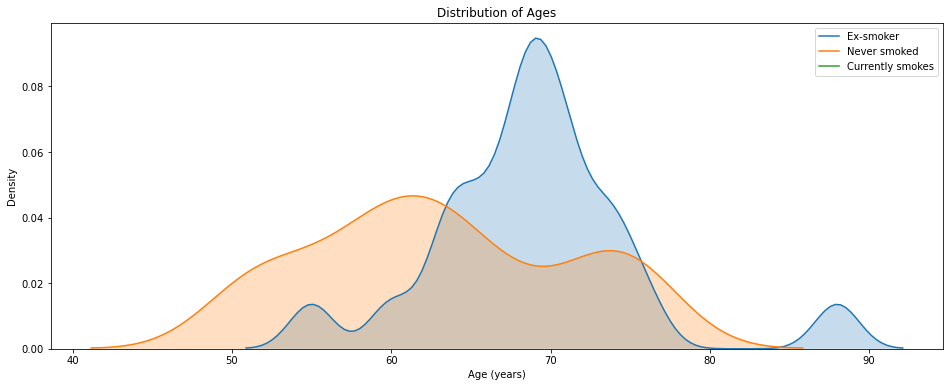

In [38]:
# code from https://www.kaggle.com/piantic/osic-pulmonary-fibrosis-progression-basic-eda
plt.figure(figsize=(16, 6))
sns.kdeplot(merged_data.loc[merged_data['SmokingStatus'] == 'Ex-smoker', 'Age'], label = 'Ex-smoker',shade=True)
sns.kdeplot(merged_data.loc[merged_data['SmokingStatus'] == 'Never smoked', 'Age'], label = 'Never smoked',shade=True)
sns.kdeplot(merged_data.loc[merged_data['SmokingStatus'] == 'Currently smokes', 'Age'], label = 'Currently smokes', shade=True)

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [39]:
merged_data

,Weeks,Patient,Predicted FVC,True FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld,Absolute Error
0,-3,ID00023637202179104603099,1527.684593,1536,65.306122,71,Female,Ex-smoker,-3,0,0.261761,0.578947,8.315407
1,3,ID00023637202179104603099,1500.614115,1368,58.163265,71,Female,Ex-smoker,-3,6,0.201730,0.578947,132.614115
2,5,ID00023637202179104603099,1491.590622,1361,57.865646,71,Female,Ex-smoker,-3,8,0.199228,0.578947,130.590622
3,7,ID00023637202179104603099,1482.567129,1465,62.287415,71,Female,Ex-smoker,-3,10,0.236391,0.578947,17.567129
4,9,ID00023637202179104603099,1473.543636,1681,71.471088,71,Female,Ex-smoker,-3,12,0.313574,0.578947,207.456364
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,21,ID00421637202311550012437,2801.456878,2820,84.471603,68,Male,Ex-smoker,15,6,0.422836,0.500000,18.543122
308,23,ID00421637202311550012437,2794.842955,2853,85.460101,68,Male,Ex-smoker,15,8,0.431144,0.500000,58.157045
309,29,ID00421637202311550012437,2775.001188,2716,81.356338,68,Male,Ex-smoker,15,14,0.396654,0.500000,59.001188
310,41,ID00421637202311550012437,2735.317654,2833,84.861011,68,Male,Ex-smoker,15,26,0.426109,0.500000,97.682346


In [40]:
age_range1 = merged_data[merged_data["Age"] <= 65]
age_range2 = merged_data[(merged_data["Age"] > 65) & (merged_data['Age'] <= 71)]
age_range3 = merged_data[merged_data["Age"] > 71]
                          
a1_rmse = calculate_rmse(age_range1)
a2_rmse = calculate_rmse(age_range2)
a3_rmse = calculate_rmse(age_range3)
print(f"{age_range1.shape[0]} {a1_rmse}, {age_range2.shape[0]} {a2_rmse}, {age_range3.shape[0]} {a3_rmse}")

134 155.95741715829035, 110 98.37369230682027, 68 168.49606195644947


In [45]:
# Get train sizes
print(train[train['Age'] <= 65].shape[0])
print(train[(train["Age"] > 65) & (train['Age'] <= 71)].shape[0])
print(train[train['Age'] > 71].shape[0])

488

In [41]:
# PLot of absolute errors
fig = px.scatter(merged_data, x="Age", y ="Absolute Error")
fig.show()

In [ ]:
rmse = calculate_rmse(merged_data)

In [ ]:
# 144.413 (for pyotrch part 2 rmse)
# around 142 for this version
rmse 

In [ ]:
#rmse for unscaled notebook with percent included = 143.2077201851251

In [ ]:
y_test = merged_data["True FVC"]
y_pred = merged_data["Predicted FVC"]

In [ ]:
y_test

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(y_test, y_pred))
rms

In [ ]:
import matplotlib.pyplot as plt # Impot the relevant module

#fig, ax = plt.subplots() # Create the figure and axes object

ax = y_test.plot()
y_pred.plot(ax=ax)
plt.suptitle('CNN (efficientnet) + MLP best model predictions vs label')
plt.legend(loc="upper left")
plt.xlabel('Patient Data Points')
plt.ylabel('FVC score')
ax.set_xticklabels([])
plt.savefig('foo.png')